In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import pickle
import json
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 11)}, font_scale=2)
sns.set_style("whitegrid")

from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KernelDensity
from sklearn import metrics
from scipy.signal import find_peaks, peak_widths


# Import Custom packages
import sys
sys.path.append('../../')
import utils
import semantic_type_propagation as stp

# Functions

In [59]:
def get_vals_in_range(m, lower_bound=0, upper_bound=0.99):
    '''
    Given a numpy array `m`, return a list with all values in `m` that are within range specified by `lower_bound` and `upper_bound` 
    '''
    m_list = m.flatten().tolist()
    m_list = [val for val in m_list if  lower_bound < val < upper_bound]
    return m_list 


def get_epsilon(m, lower_bound=0, upper_bound=0.99, mode='greatest', num_samples=1000, rel_height=1, bandwidth_multiplier=20, dynamic_num_samples=False, log_base=10):
    '''
    m is a distance matrix

    Whenever 'm_list' is empty return an epsilon of 1-`upper_bound`

    mode must be one of 'kde' or 'greatest' 
    '''
    m_list = get_vals_in_range(m, lower_bound=lower_bound, upper_bound=upper_bound)

    # Check if m_list is empty
    if len(m_list) == 0:
        epsilon = 1-upper_bound
        # Ensure that epsilon is greater than 0 (if not set it to a default value of 0.5)
        if epsilon <= 0:
            epsilon = 0.5 
        return epsilon
    
    if mode == 'greatest':
        return max(m_list)
    elif mode == 'kde':
        # TODO: Dynamically figure out the number of samples
        density, samples, lower_bnd, upper_bnd = get_kde(m_list, bandwidth_multiplier=bandwidth_multiplier, num_samples=num_samples, dynamic_num_samples=dynamic_num_samples, log_base=log_base)
        widths, width_heights, left_pos, right_pos = get_peak_widths(
            density=density,
            lower_bnd=lower_bnd,
            upper_bnd=upper_bnd,
            num_samples=len(samples),
            rel_height=rel_height
        )

        if len(widths) == 0:
            # No peak was found just set epsilon to a default value of 0.5
            epsilon = 0.5
        elif len(widths) > 1:
            # Do not consider the last peak as it corresponds to distances across different types

            # Sometimes the range of the last peak is within the range of the second to last peak,
            # similarly the width of the second to last peak is within the range of the last peak. Ensure we account for all these cases
            
            # Second two last peak start and end points
            s1 = left_pos[-2]
            e1 = right_pos[-2]

            # Last peak start and end points
            s2 = left_pos[-1]
            e2 = right_pos[-1]

            if e1 < s2:
                # Case 1: There is no overlap between the last peak and the second to last peak
                epsilon = max(right_pos[:-1])
            elif ((s1 < s2) and (e1 > e2)):
                # Case 2: The last peak's range is within the range of the second to last peak
                epsilon = s2
            elif ((s2 < s1) and (e2 > e1)):
                # Case 3: The second two last peak's range is within the range of the last peak
                epsilon = e1

            # Sometimes the max of the second to last peak is greater than the min of the last peak (ensure to pick the smallest of the two values)
            # epsilon = min(max(right_pos[:-1]), max(left_pos))
        else:
            # There is only one peak. Choose the left_pos instead
            epsilon = max(left_pos)

        if epsilon >= 1:
            # Ensure that epsilon is less than 1
            positive_right_pos = [val for val in right_pos if val < 1]
            epsilon = max(positive_right_pos)

        return epsilon
        

def get_kde(vals, bandwidth_multiplier=20, num_samples=1000, boundary_proportion=0.1, dynamic_num_samples=False, log_base=10):
    '''
    Given a list of uniformly seperated values `vals` estimate density distribution using KDE

    The range of the samples is specified

    Returns two lists, the density and the samples at which the density is estimated at
    '''

    # Compute the range of `vals` and assign upper and lower boundaries for the samples 
    vals_range = max(vals) - min(vals)

    if vals_range == 0:
        # If all values in `vals` have the same value then set the lower bound to 0 and the upper bound to 1
        samples_lower_bnd = 0
        samples_upper_bnd = 1
    else:
        samples_lower_bnd = min(vals) - boundary_proportion*vals_range
        samples_upper_bnd = max(vals) + boundary_proportion*vals_range

    if dynamic_num_samples:
        # The number of samples are dynamical set depending on the `vals_range`
        num_samples = math.ceil(num_samples / (1 - math.log(samples_upper_bnd - samples_lower_bnd, log_base)))

    # Compute the KDE curve
    points = np.array(np.array(vals)).reshape(-1,1)
    kde = KernelDensity(kernel='gaussian', bandwidth=((samples_upper_bnd - samples_lower_bnd)/num_samples)*bandwidth_multiplier).fit(points)
    samples = np.linspace(samples_lower_bnd, samples_upper_bnd, num=num_samples)
    density = np.exp(kde.score_samples(samples.reshape(-1,1)))

    return density, samples, samples_lower_bnd, samples_upper_bnd

def get_peak_widths(density, lower_bnd, upper_bnd, num_samples, rel_height=0.5):
    '''
    Returns 4 lists all in the original space:

    widths: the widths for each peak 
    width_heights: the heights where the widths are evaluated
    left_pos: the positions of the left intersepction points of the horizontal line with the evaluation height
    right_pos: the positions of the right intersepction points of the horizontal line with the evaluation height
    '''
    # Find the peaks
    peaks, _ = find_peaks(density)

    # Find the widths of each peak with their respective locations and height
    widths, width_heights, left_ips, right_ips = peak_widths(density, peaks, rel_height=rel_height)

    range_length = upper_bnd - lower_bnd
    length_per_sample = range_length / num_samples

    # Convert the left_ips and right_ips from the sample space to the original space (0-1)
    widths = widths * length_per_sample
    left_pos = (left_ips * length_per_sample) + lower_bnd
    right_pos = (right_ips * length_per_sample) + lower_bnd

    return widths, width_heights, left_pos, right_pos

def get_num_meanings(df, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=1000, rel_height=0.999, bandwidth_multiplier=20, dynamic_num_samples=False, log_base=10):
    '''
    Takes a dataframe with the nodes for which the number of meanings is to be evaluated.
    It finds the number of meanings using both the 'greatest' and 'KDE' approach

    Returns 3 items:
    
    1. An updated dataframe with the new columns populated
    2. A dictionary mapping the attributes of each node to their clusters identified by DBSCAN (using greatest epsilon)
    3. A dictionary mapping the attributes of each node to their clusters identified by DBSCAN (using epsilon identified via KDE)
    '''
    df['num_meanings_greatest'] = np.nan
    df['num_meanings_kde'] = np.nan
    df['epsilon_greatest'] = np.nan
    df['epsilon_kde'] = np.nan
    df['is_trivial_prediction'] = np.nan
    num_non_trivial_predictions = 0

    node_to_clusters_greatest = {}
    node_to_clusters_kde = {}

    # Loop over the input nodes and estimate the number of meanings 
    for node in df['node']:
        # Check number of attributes 'node' is connected to, if 2 or less then set it to have two meanings
        if len(utils.graph_helpers.get_attribute_of_instance(G, node)) > 2:
            m = node_to_matrix_dict[node]

            # Get the epsilon using both modes
            epsilon_greatest = get_epsilon(m, lower_bound=lower_bound, upper_bound=0.99, mode='greatest', num_samples=num_samples, rel_height=rel_height, bandwidth_multiplier=bandwidth_multiplier)
            epsilon_kde = get_epsilon(m, lower_bound=lower_bound, upper_bound=upper_bound, mode='kde', num_samples=num_samples, rel_height=rel_height, bandwidth_multiplier=bandwidth_multiplier, dynamic_num_samples=dynamic_num_samples, log_base=log_base)

            # Run DBSCAN over the matrix with the specified epsilon
            labels_greatest = DBSCAN(min_samples=1, metric='precomputed', eps=epsilon_greatest).fit_predict(m)
            labels_kde = DBSCAN(min_samples=1, metric='precomputed', eps=epsilon_kde).fit_predict(m)

            # Save the labels extracted by DBSCAN
            node_to_clusters_greatest[node] = labels_greatest
            node_to_clusters_kde[node] = labels_kde

            # Extract number of meanings as the number of communities detected by DBSCAN
            num_meanings_greatest = len(set(labels_greatest))
            num_meanings_kde = len(set(labels_kde))

            df.loc[df['node'] == node, 'num_meanings_greatest'] = num_meanings_greatest
            df.loc[df['node'] == node, 'num_meanings_kde'] = num_meanings_kde
            df.loc[df['node'] == node, 'epsilon_greatest'] = epsilon_greatest
            df.loc[df['node'] == node, 'epsilon_kde'] = epsilon_kde
            df.loc[df['node'] == node, 'is_trivial_prediction'] = False
            num_non_trivial_predictions+=1
        else:
            df.loc[df['node'] == node, 'num_meanings_greatest'] = 2
            df.loc[df['node'] == node, 'num_meanings_kde'] = 2
            df.loc[df['node'] == node, 'is_trivial_prediction'] = True

            # There are only two attribute nodes so assign a different type to each (i.e. [0, 1])
            node_to_clusters_greatest[node] = [0, 1]
            node_to_clusters_kde[node] = [0, 1]


    df['is_kde_num_meanings_correct'] = df['num_meanings_kde'] == df['num_meanings_groundtruth']
    df['is_greatest_num_meanings_correct'] = df['num_meanings_greatest'] == df['num_meanings_groundtruth']

    return df, node_to_clusters_greatest, node_to_clusters_kde

def get_clustering_evaluation_score(labels_pred, idx_to_nodes, G, measure='adj_rand_index'):
    '''
    Given `labels_pred` which is an assignment of types for the attributes of a node, derive the groundtruth
    using `idx_to_nodes` and `G` and return the specified clustering evaluation `measure` 

    Allowed measures: ['adj_rand_index', 'adj_mutual_info', 'norm_mutual_info']
    '''
    # Derive the groundtruth labels by getting the column name for each attribute in the idx_to_nodes list
    col_names = [G.nodes[attr]['column_name'] for attr in idx_to_nodes.values()]
    col_name_to_label_dict = dict([(y,x) for x,y in enumerate(sorted(set(col_names)))])
    labels_true = [col_name_to_label_dict[x] for x in col_names]
    
    if measure == 'adj_rand_index':
        score = metrics.adjusted_rand_score(labels_true=labels_true, labels_pred=labels_pred)
    elif measure == 'adj_mutual_info':
        score = metrics.adjusted_mutual_info_score(labels_true=labels_true, labels_pred=labels_pred)
    elif measure == 'norm_mutual_info':
        score = metrics.normalized_mutual_info_score(labels_true=labels_true, labels_pred=labels_pred)

    return score

def run_cluster_evaluation_df(df, G, labels_greatest, labels_kde, node_to_idx_dict, input_nodes):
    '''
    Update a dataframe by adding clustering evaluation columns for its nodes 
    '''
    df['greatest_adj_rand_index'] = np.nan
    df['greatest_adj_mutual_info'] = np.nan
    df['greatest_norm_mutual_info'] = np.nan
    df['kde_adj_rand_index'] = np.nan
    df['kde_adj_mutual_info'] = np.nan
    df['kde_norm_mutual_info'] = np.nan
    for node in input_nodes:
        df.loc[df['node'] == node, 'greatest_adj_rand_index'] = get_clustering_evaluation_score(labels_pred=labels_greatest[node], idx_to_nodes=node_to_idx_dict[node], G=G, measure='adj_rand_index')
        df.loc[df['node'] == node, 'greatest_adj_mutual_info'] = get_clustering_evaluation_score(labels_pred=labels_greatest[node], idx_to_nodes=node_to_idx_dict[node], G=G, measure='adj_mutual_info')
        df.loc[df['node'] == node, 'greatest_norm_mutual_info'] = get_clustering_evaluation_score(labels_pred=labels_greatest[node], idx_to_nodes=node_to_idx_dict[node], G=G, measure='norm_mutual_info')
        df.loc[df['node'] == node, 'kde_adj_rand_index'] = get_clustering_evaluation_score(labels_pred=labels_kde[node], idx_to_nodes=node_to_idx_dict[node], G=G, measure='adj_rand_index')
        df.loc[df['node'] == node, 'kde_adj_mutual_info'] = get_clustering_evaluation_score(labels_pred=labels_kde[node], idx_to_nodes=node_to_idx_dict[node], G=G, measure='adj_mutual_info')
        df.loc[df['node'] == node, 'kde_norm_mutual_info'] = get_clustering_evaluation_score(labels_pred=labels_kde[node], idx_to_nodes=node_to_idx_dict[node], G=G, measure='norm_mutual_info')
    
    return df

In [3]:
def get_density_fig_for_node(node, fig, node_to_matrix_dict, num_samples=1000, boundary_proportion=0.1, bandwidth_multiplier=20, dynamic_num_samples=True, log_base=10, rel_height=0.999):
    '''
    Create the KDE distribution plot for a given ndoe
    '''
    vals = get_vals_in_range(node_to_matrix_dict[node], lower_bound=0, upper_bound=1)
    density, samples, samples_lower_bnd, samples_upper_bnd = get_kde(vals, bandwidth_multiplier=bandwidth_multiplier, num_samples=num_samples, boundary_proportion=boundary_proportion, dynamic_num_samples=dynamic_num_samples, log_base=log_base)
    print('Using:', len(samples), 'samples')
    widths, width_heights, left_pos, right_pos = get_peak_widths(density, samples_lower_bnd, samples_upper_bnd, num_samples=len(samples), rel_height=rel_height)
    print('Widths:', widths, 'Width Lengths:', width_heights, 'Peak left boundaries:', left_pos, 'Peak right boundaries:', right_pos)

    epsilon = get_epsilon(node_to_matrix_dict[node], lower_bound=0, upper_bound=1, mode='kde', num_samples=len(samples), rel_height=rel_height, bandwidth_multiplier=bandwidth_multiplier, dynamic_num_samples=dynamic_num_samples, log_base=log_base)
    print('Epsilon:', epsilon)

    labels = DBSCAN(min_samples=1, metric='precomputed', eps=epsilon).fit_predict(node_to_matrix_dict[node])
    print("Labels", labels)

    # Make the Plot
    ax = fig.add_subplot(1,1,1) # here is where you add the subplot to f
    plt.plot(samples, density)
    plt.hlines(y=width_heights, xmin=left_pos, xmax=right_pos, colors='red')
    plt.ylabel('Density', fontsize=35);plt.xlabel('Pairwise Distances', fontsize=35);plt.tight_layout()
    return fig
    

# Jaccard Similarity (Synthetic Dataset)

In [66]:
df_path = '../../output/synthetic_example_large/'
g_path = '../../../graph_construction/combined_graphs_output/synthetic_benchmark_large/bipartite/bipartite.graph'
input_nodes_json_path = '../../input/synthetic_large/input_nodes.json'
matrices_path = df_path + 'num_meanings/jaccard/matrices/'

df = pd.read_pickle(df_path + 'graph_stats_with_groundtruth_df.pickle')
G = pickle.load(open(g_path, "rb"))

with open(input_nodes_json_path) as f:
  input_nodes = json.load(f)['input_nodes']

# Remove nodes with degree 1 from the dataframe
df = stp.process_df(df, G)

# Compute the groundtruth for the number of meanings for each homograph
df = utils.num_meanings.get_num_meanings_groundtruth(df, G)
df_homs = df[df['is_homograph']==True].sort_values(by='betweenness_centrality', ascending=False)
df_homs

100%|██████████| 180/180 [00:00<00:00, 3423.86it/s]

There are 6502 cell nodes with a degree greater than 1
There are 611 unique ranks based on BC.


,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
7590,Palm,cell,1.445700e-02,True,1.0,2
25825,Clementine,cell,8.975958e-03,True,2.0,2
7130,Magnolia,cell,8.132084e-03,True,3.0,2
3077,Jaguar,cell,8.049376e-03,True,4.0,2
7416,Timothy,cell,6.921700e-03,True,5.0,2
...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2
1828,SD,cell,2.059766e-07,True,276.0,2
2004,ME,cell,1.214843e-07,True,314.0,2
1950,NC,cell,7.969017e-08,True,329.0,2


In [72]:
print("Precision/Recall/F1-score @k=180 for Domain Net:",
    df.sort_values(by='betweenness_centrality', ascending=False).iloc[:180]['is_homograph'].value_counts()[True]/180)

Precision/Recall/F1-score @k=180 for Domain Net: 0.7333333333333333


In [5]:
df_homs['num_meanings_groundtruth'].value_counts()

2    176
3      4
Name: num_meanings_groundtruth, dtype: int64

In [6]:
df_homs[df_homs['num_meanings_groundtruth'] > 2]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
300,Lincoln,cell,0.004879,True,8.0,3
2012,Montana,cell,0.002381,True,15.0,3
1401,Aurora,cell,0.001690,True,20.0,3
546,Virginia,cell,0.001467,True,25.0,3


In [7]:
# Map each input node from tje json file to its pairwise distance matrix and its index to node dictionary
node_to_matrix_dict = {}
node_to_idx_dict = {}
for node in input_nodes:
    # We subtract the matrix from one to convert it from a similarity matrix to a distance matrix
    m = 1 - np.load(matrices_path + node + '.npy')
    idx_to_node = pickle.load(open(matrices_path + node + '_idx_to_node.pickle', 'rb'))

    node_to_matrix_dict[node] = m
    node_to_idx_dict[node] = idx_to_node

In [8]:
df_input_nodes = df.copy()[df['node'].isin(input_nodes)]
df_input_nodes, labels_greatest, labels_kde = get_num_meanings(df_input_nodes, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=1000, rel_height=0.999, bandwidth_multiplier=20, dynamic_num_samples=False, log_base=2)
df_input_nodes = run_cluster_evaluation_df(df_input_nodes, G, labels_greatest, labels_kde, node_to_idx_dict)
df_input_nodes

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct,greatest_adj_rand_index,greatest_adj_mutual_info,greatest_norm_mutual_info,kde_adj_rand_index,kde_adj_mutual_info,kde_norm_mutual_info
7590,Palm,cell,1.445700e-02,True,1.0,2,2.0,2.0,0.970414,0.973208,False,True,True,1.0,1.000000e+00,1.0,1.0,1.0,1.0
25825,Clementine,cell,8.975958e-03,True,2.0,2,2.0,2.0,0.812009,0.828506,False,True,True,1.0,1.000000e+00,1.0,1.0,1.0,1.0
7130,Magnolia,cell,8.132084e-03,True,3.0,2,2.0,2.0,NaN,NaN,True,True,True,1.0,0.000000e+00,1.0,1.0,0.0,1.0
3077,Jaguar,cell,8.049376e-03,True,4.0,2,2.0,2.0,0.692718,0.763031,False,True,True,1.0,1.000000e+00,1.0,1.0,1.0,1.0
7416,Timothy,cell,6.921700e-03,True,5.0,2,2.0,2.0,NaN,NaN,True,True,True,1.0,0.000000e+00,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2,1.0,2.0,0.908497,0.446164,False,True,False,0.0,8.213631e-16,0.0,1.0,1.0,1.0
1828,SD,cell,2.059766e-07,True,276.0,2,1.0,2.0,0.913907,0.446536,False,True,False,0.0,8.213631e-16,0.0,1.0,1.0,1.0
2004,ME,cell,1.214843e-07,True,314.0,2,1.0,2.0,0.907285,0.424851,False,True,False,0.0,0.000000e+00,0.0,1.0,1.0,1.0
1950,NC,cell,7.969017e-08,True,329.0,2,1.0,2.0,0.912752,0.351996,False,True,False,0.0,4.651263e-16,0.0,1.0,1.0,1.0


In [9]:
df_input_nodes[df_input_nodes['is_trivial_prediction']==False].mean()

betweenness_centrality                0.000992
is_homograph                          1.000000
dense_rank                          106.107843
num_meanings_groundtruth              2.039216
num_meanings_greatest                 1.843137
num_meanings_kde                      2.068627
epsilon_greatest                      0.640296
epsilon_kde                           0.586947
is_trivial_prediction                 0.000000
is_kde_num_meanings_correct           0.931373
is_greatest_num_meanings_correct      0.803922
greatest_adj_rand_index               0.803922
greatest_adj_mutual_info              0.803922
greatest_norm_mutual_info             0.803922
kde_adj_rand_index                    0.964734
kde_adj_mutual_info                   0.964221
kde_norm_mutual_info                  0.971631
dtype: float64

In [10]:
print('Greatest distribution:', df_input_nodes['is_greatest_num_meanings_correct'].value_counts())
print('KDE distribution:', df_input_nodes['is_kde_num_meanings_correct'].value_counts())

Greatest distribution: True     160
False     20
Name: is_greatest_num_meanings_correct, dtype: int64
KDE distribution: True     173
False      7
Name: is_kde_num_meanings_correct, dtype: int64


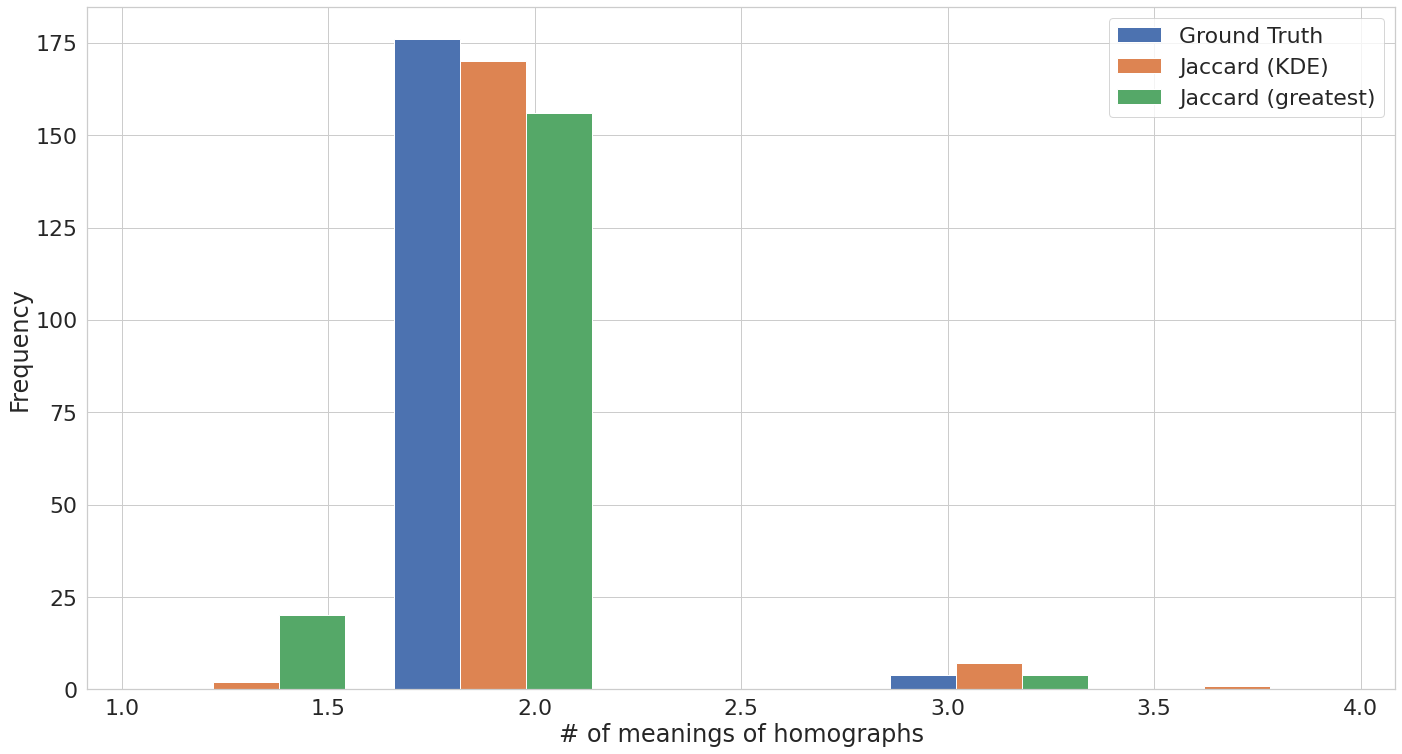

In [11]:
ax = plt.hist([df_input_nodes['num_meanings_groundtruth'], df_input_nodes['num_meanings_kde'], df_input_nodes['num_meanings_greatest']], bins=5, label=['Ground Truth', 'Jaccard (KDE)', 'Jaccard (greatest)'])
plt.xlabel('# of meanings of homographs');plt.ylabel('Frequency');plt.legend();plt.tight_layout()
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/num_meanings_histogram.svg')

In [12]:
df_input_nodes[df_input_nodes['is_kde_num_meanings_correct'] == False]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct,greatest_adj_rand_index,greatest_adj_mutual_info,greatest_norm_mutual_info,kde_adj_rand_index,kde_adj_mutual_info,kde_norm_mutual_info
300,Lincoln,cell,0.004879,True,8.0,3,3.0,4.0,0.983322,0.623339,False,False,True,1.0,1.0,1.0,0.740741,7.672359e-01,0.880421
24153,Darcy,cell,0.001545,True,23.0,2,2.0,1.0,0.988259,0.997867,False,False,True,1.0,1.0,1.0,0.000000,4.651263e-16,0.000000
275,Elmira,cell,0.001444,True,26.0,2,2.0,1.0,0.983322,0.997756,False,False,True,1.0,1.0,1.0,0.000000,4.651263e-16,0.000000
1174,Chicago,cell,0.001432,True,27.0,2,2.0,3.0,0.978523,0.589618,False,False,True,1.0,1.0,1.0,0.571429,5.714286e-01,0.800000
590,Brooklyn,cell,0.001227,True,31.0,2,2.0,3.0,0.983322,0.589633,False,False,True,1.0,1.0,1.0,0.333333,4.206198e-01,0.702017
723,Jamaica,cell,0.001169,True,33.0,2,2.0,3.0,0.981066,0.841035,False,False,True,1.0,1.0,1.0,0.974766,8.786539e-01,0.894711
18618,Kansas,cell,0.000264,True,80.0,2,2.0,3.0,0.978523,0.199021,False,False,True,1.0,1.0,1.0,0.782609,7.125940e-01,0.829199


Using: 12000 samples
Widths: [0.01229996 0.01228201 0.01229876 0.01229967 0.01329738 0.01464113] Width Lengths: [0.01148339 0.01171233 0.0114821  0.01148308 0.04584534 0.12495995] Peak left boundaries: [0.16571793 0.23194206 0.24780586 0.5438861  0.97549004 0.99023565] Peak right boundaries: [0.1780179  0.24422407 0.26010462 0.55618577 0.98878742 1.00487678]
Epsilon: 0.988787417017755
Labels [0 0 0 1 1 1 2]


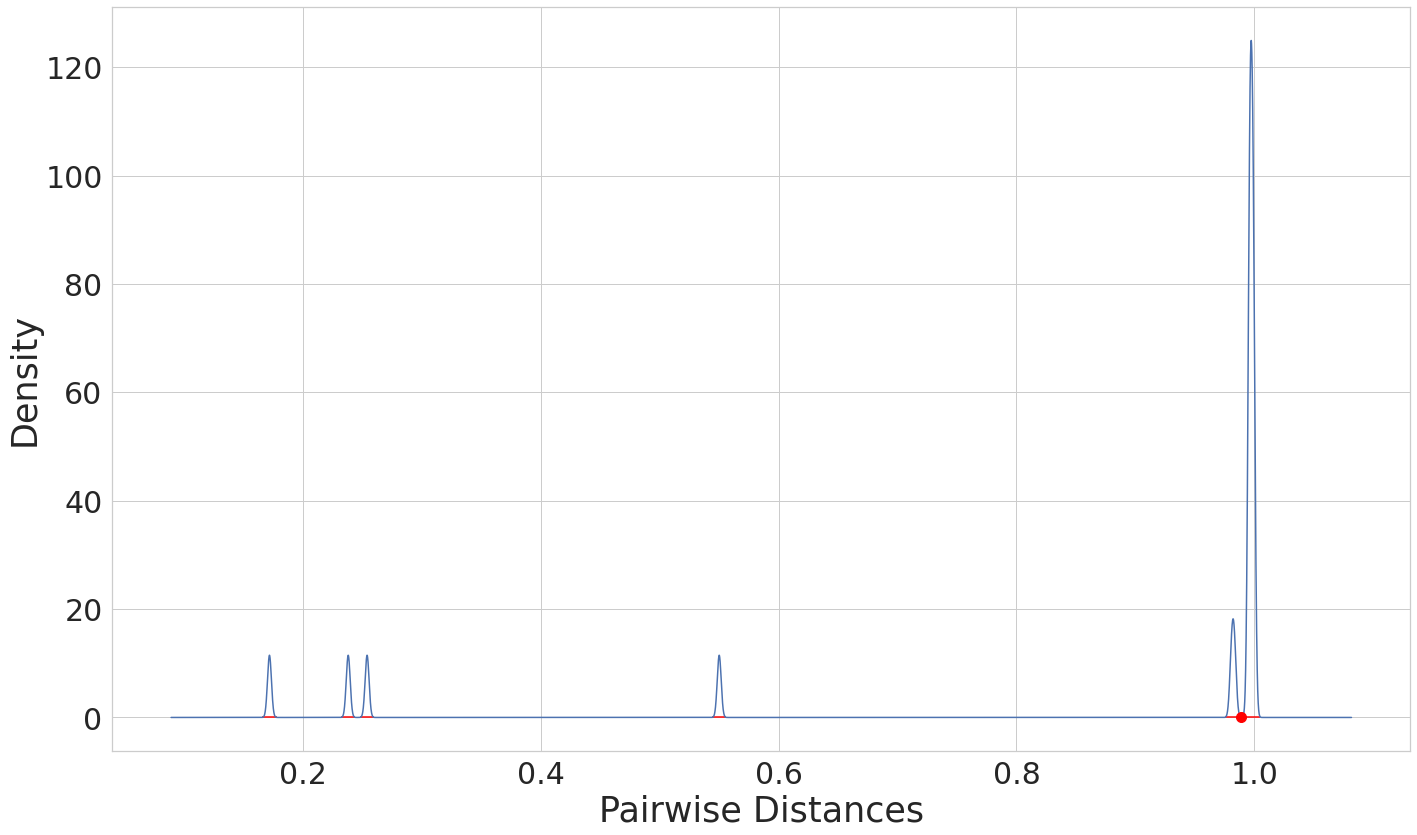

In [13]:
f = plt.figure(figsize=(20, 12))
f = get_density_fig_for_node('Lincoln', fig=f, node_to_matrix_dict=node_to_matrix_dict, num_samples=12000, boundary_proportion=0.1, bandwidth_multiplier=20, dynamic_num_samples=False, log_base=10, rel_height=0.999)
plt.scatter(0.9887, 0, zorder=10, s=100, c='red');plt.xticks(fontsize=30);plt.yticks(fontsize=30)
f.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/lincoln_12000.pdf')
f.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/lincoln_12000.svg')

Using: 1000 samples
Widths: [0.0523604  0.22201812 0.14745897 0.15146126] Width Lengths: [0.51663411 0.00193015 0.00095694 0.01764626] Peak left boundaries: [0.14977023 0.10191235 0.47588009 0.91801548] Peak right boundaries: [0.20213063 0.32393047 0.62333906 1.06947674]
Epsilon: 0.6233390582925663
Labels [0 0 0 1 2 2 3]


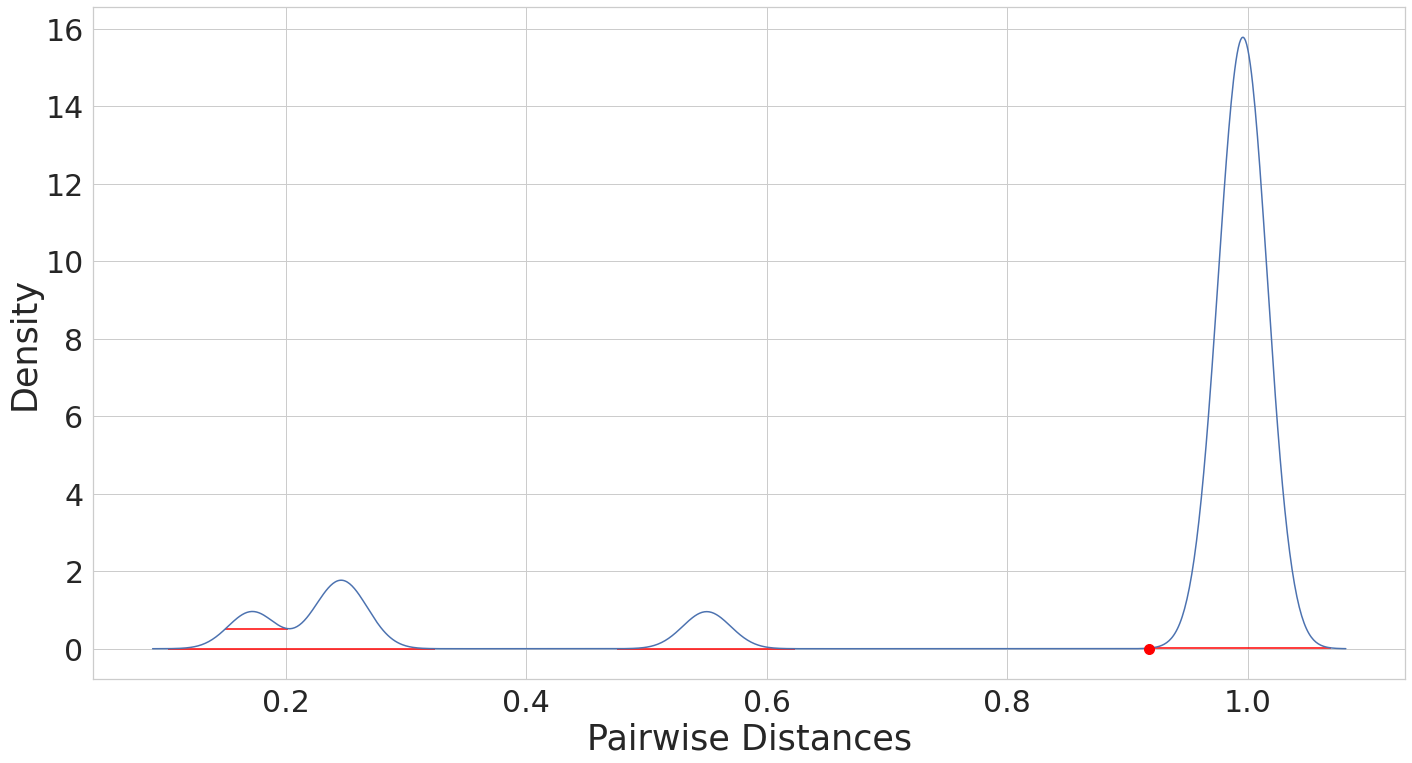

In [14]:
f = plt.figure(figsize=(20, 11))
f = get_density_fig_for_node('Lincoln', fig=f, node_to_matrix_dict=node_to_matrix_dict, num_samples=1000, boundary_proportion=0.1, bandwidth_multiplier=20, dynamic_num_samples=False, log_base=10, rel_height=0.999)
plt.scatter(0.918, 0, zorder=10, s=100, c='red');plt.xticks(fontsize=30);plt.yticks(fontsize=30)
f.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/lincoln_1000.pdf')
f.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/lincoln_1000.svg')

## Number of Samples Experiment

In [15]:
samples_to_df_dict = {}
dynamic_samples_to_df_dict = {}

for samples in tqdm(range(200, 10000, 100)):
    df_tmp = df.copy()[df['node'].isin(input_nodes)]
    df_tmp, labels_greatest_tmp, labels_kde_tmp = get_num_meanings(df_tmp, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=samples, rel_height=0.999, bandwidth_multiplier=20)
    df_tmp = run_cluster_evaluation_df(df_tmp, G, labels_greatest_tmp, labels_kde_tmp, node_to_idx_dict)
    samples_to_df_dict[samples] = df_tmp

    df_tmp = df.copy()[df['node'].isin(input_nodes)]
    df_tmp, labels_greatest_tmp, labels_kde_tmp = get_num_meanings(df_tmp, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=samples, rel_height=0.999, bandwidth_multiplier=20, dynamic_num_samples=True, log_base=2)
    df_tmp = run_cluster_evaluation_df(df_tmp, G, labels_greatest_tmp, labels_kde_tmp, node_to_idx_dict)
    dynamic_samples_to_df_dict[samples] = df_tmp

100%|██████████| 98/98 [06:06<00:00,  3.74s/it]


In [16]:
def get_num_samples_eval_df(samples_to_df_dict):
    samples_to_statistics_dict = {'samples': [], 'precision_kde': [], 'precision_greatest': [], 'greatest_adj_rand_index': [], 'greatest_norm_mutual_info': [], 'kde_adj_rand_index': [], 'kde_norm_mutual_info': []}
    for num_samples, df_tmp in samples_to_df_dict.items():
        precision_kde = df_tmp['is_kde_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
        precision_greatest = df_tmp['is_greatest_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
        samples_to_statistics_dict['samples'].append(num_samples)
        samples_to_statistics_dict['precision_kde'].append(precision_kde)
        samples_to_statistics_dict['precision_greatest'].append(precision_greatest)

        samples_to_statistics_dict['greatest_adj_rand_index'].append(df_tmp['greatest_adj_rand_index'].mean())
        samples_to_statistics_dict['greatest_norm_mutual_info'].append(df_tmp['greatest_norm_mutual_info'].mean())
        samples_to_statistics_dict['kde_adj_rand_index'].append(df_tmp['kde_adj_rand_index'].mean())
        samples_to_statistics_dict['kde_norm_mutual_info'].append(df_tmp['kde_norm_mutual_info'].mean())

    samples_to_statistics_df = pd.DataFrame.from_dict(samples_to_statistics_dict)
    return samples_to_statistics_df

In [17]:
samples_to_statistics_df = get_num_samples_eval_df(samples_to_df_dict)
dyn_samples_to_statistics_df = get_num_samples_eval_df(dynamic_samples_to_df_dict)

In [18]:
samples_to_statistics_dict = {'samples': [], 'precision_kde': [], 'precision_greatest': [], 'greatest_adj_rand_index': [], 'greatest_norm_mutual_info': [], 'kde_adj_rand_index': [], 'kde_norm_mutual_info': []}
dyn_samples_to_statistics_dict = {'samples': [], 'precision_kde': [], 'precision_greatest': [], 'greatest_adj_rand_index': [], 'greatest_norm_mutual_info': [], 'kde_adj_rand_index': [], 'kde_norm_mutual_info': []}
for num_samples, df_tmp in samples_to_df_dict.items():
    precision_kde = df_tmp['is_kde_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
    precision_greatest = df_tmp['is_greatest_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
    samples_to_statistics_dict['samples'].append(num_samples)
    samples_to_statistics_dict['precision_kde'].append(precision_kde)
    samples_to_statistics_dict['precision_greatest'].append(precision_greatest)

    samples_to_statistics_dict['greatest_adj_rand_index'].append(df_tmp['greatest_adj_rand_index'].mean())
    samples_to_statistics_dict['greatest_norm_mutual_info'].append(df_tmp['greatest_norm_mutual_info'].mean())
    samples_to_statistics_dict['kde_adj_rand_index'].append(df_tmp['kde_adj_rand_index'].mean())
    samples_to_statistics_dict['kde_norm_mutual_info'].append(df_tmp['kde_norm_mutual_info'].mean())

samples_to_statistics_df = pd.DataFrame.from_dict(samples_to_statistics_dict)
samples_to_statistics_df.head()

,samples,precision_kde,precision_greatest,greatest_adj_rand_index,greatest_norm_mutual_info,kde_adj_rand_index,kde_norm_mutual_info
0,200,0.950000,0.888889,0.888889,0.888889,0.987437,0.991143
1,300,0.966667,0.888889,0.888889,0.888889,0.985572,0.989480
2,400,0.961111,0.888889,0.888889,0.888889,0.980016,0.983924
3,500,0.961111,0.888889,0.888889,0.888889,0.980016,0.983924
4,600,0.961111,0.888889,0.888889,0.888889,0.980016,0.983924


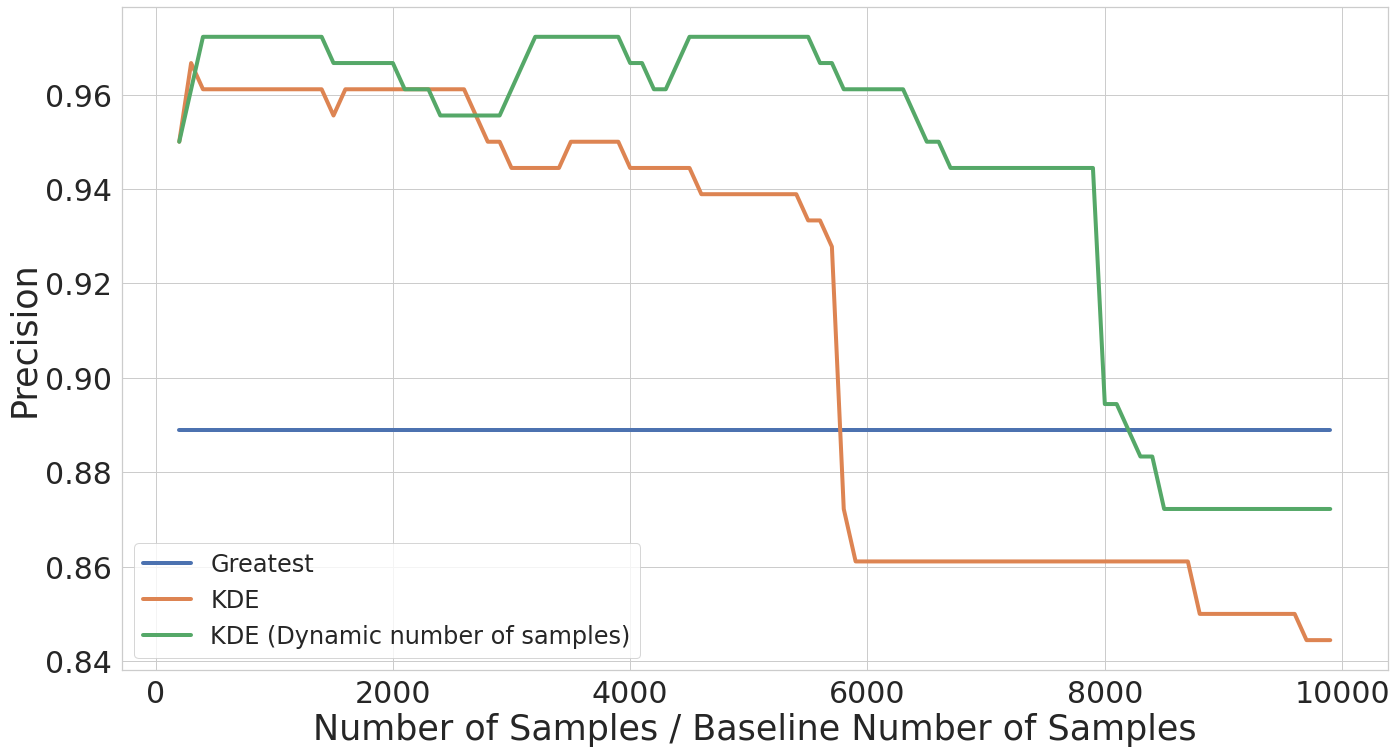

In [19]:
plt.plot(samples_to_statistics_df['samples'], samples_to_statistics_df['precision_greatest'], label='Greatest', linewidth=4)
plt.plot(samples_to_statistics_df['samples'], samples_to_statistics_df['precision_kde'], label='KDE', linewidth=4)
plt.plot(dyn_samples_to_statistics_df['samples'], dyn_samples_to_statistics_df['precision_kde'], label='KDE (Dynamic number of samples)', linewidth=4)

plt.xticks(fontsize=30);plt.yticks(fontsize=30)
plt.legend(fontsize=24);plt.ylabel('Precision', fontsize=35);plt.xlabel('Number of Samples / Baseline Number of Samples', fontsize=35);plt.tight_layout()
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/num_samples_precision.pdf')
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/num_samples_precision.svg')

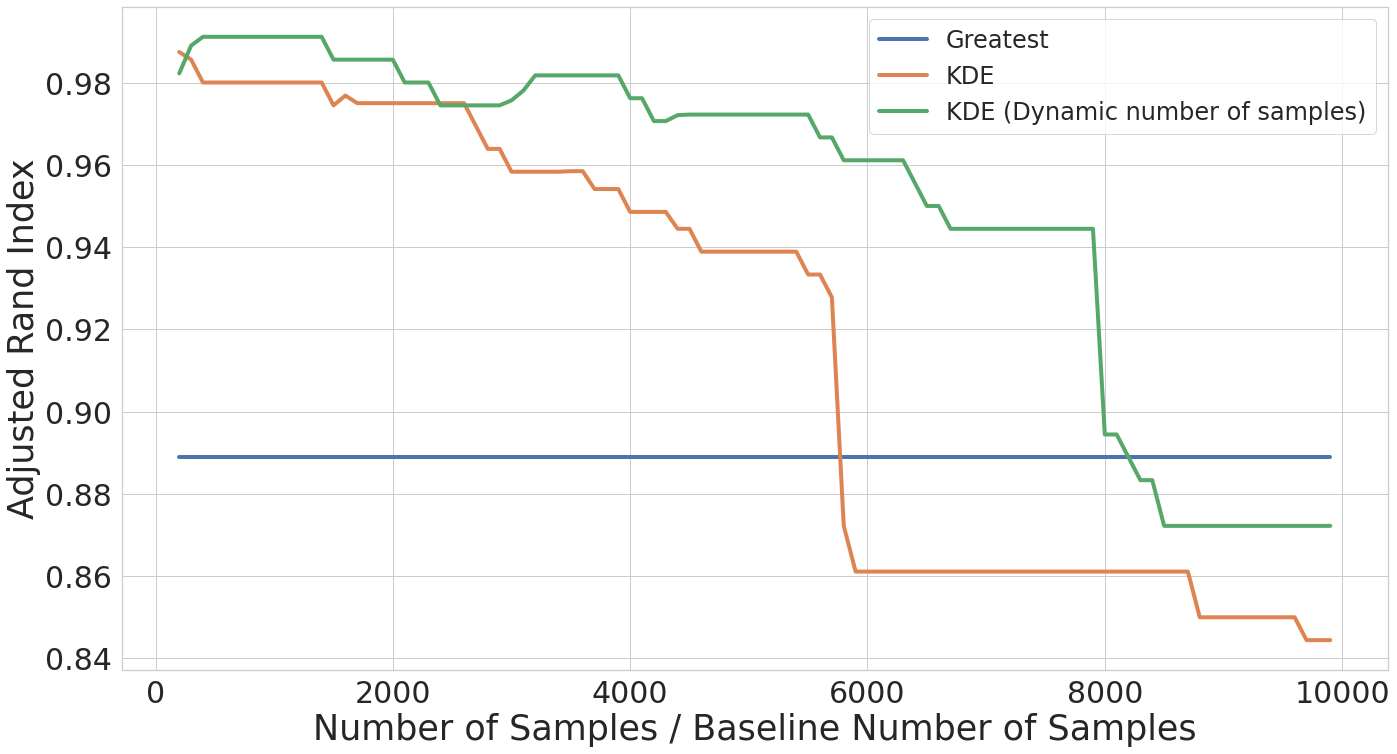

In [20]:
# Evaluate the clustering
plt.plot(samples_to_statistics_df['samples'], samples_to_statistics_df['greatest_adj_rand_index'], label='Greatest', linewidth=4)
plt.plot(samples_to_statistics_df['samples'], samples_to_statistics_df['kde_adj_rand_index'], label='KDE', linewidth=4)
plt.plot(dyn_samples_to_statistics_df['samples'], dyn_samples_to_statistics_df['kde_adj_rand_index'], label='KDE (Dynamic number of samples)', linewidth=4)

plt.legend(fontsize=24);plt.ylabel('Adjusted Rand Index', fontsize=35);plt.xlabel('Number of Samples / Baseline Number of Samples', fontsize=35);plt.xticks(fontsize=30);plt.yticks(fontsize=30);plt.tight_layout()
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/clustering_evaluation.pdf')
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/clustering_evaluation.svg')

## Relative Height Experiment

In [85]:
rel_height_to_df_dict = {}

for rel_height in tqdm(np.arange(0.97, 1, 0.0005)):
    df_tmp = df.copy()[df['node'].isin(input_nodes)]
    df_tmp = get_num_meanings(df_tmp, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=1000, rel_height=rel_height, bandwidth_multiplier=20)
    rel_height_to_df_dict[rel_height] = df_tmp

100%|██████████| 61/61 [00:23<00:00,  2.64it/s]


In [86]:
rel_height_to_precision_dict = {'rel_height': [], 'precision_kde': [], 'precision_greatest': []}
for rel_height, df_tmp in rel_height_to_df_dict.items():
    precision_kde = df_tmp['is_kde_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
    precision_greatest = df_tmp['is_greatest_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
    rel_height_to_precision_dict['rel_height'].append(rel_height)
    rel_height_to_precision_dict['precision_kde'].append(precision_kde)
    rel_height_to_precision_dict['precision_greatest'].append(precision_greatest)

rel_height_to_precision_df = pd.DataFrame.from_dict(rel_height_to_precision_dict)
rel_height_to_precision_df.head()

,rel_height,precision_kde,precision_greatest
0,0.9700,0.961111,0.888889
1,0.9705,0.961111,0.888889
2,0.9710,0.961111,0.888889
3,0.9715,0.961111,0.888889
4,0.9720,0.961111,0.888889


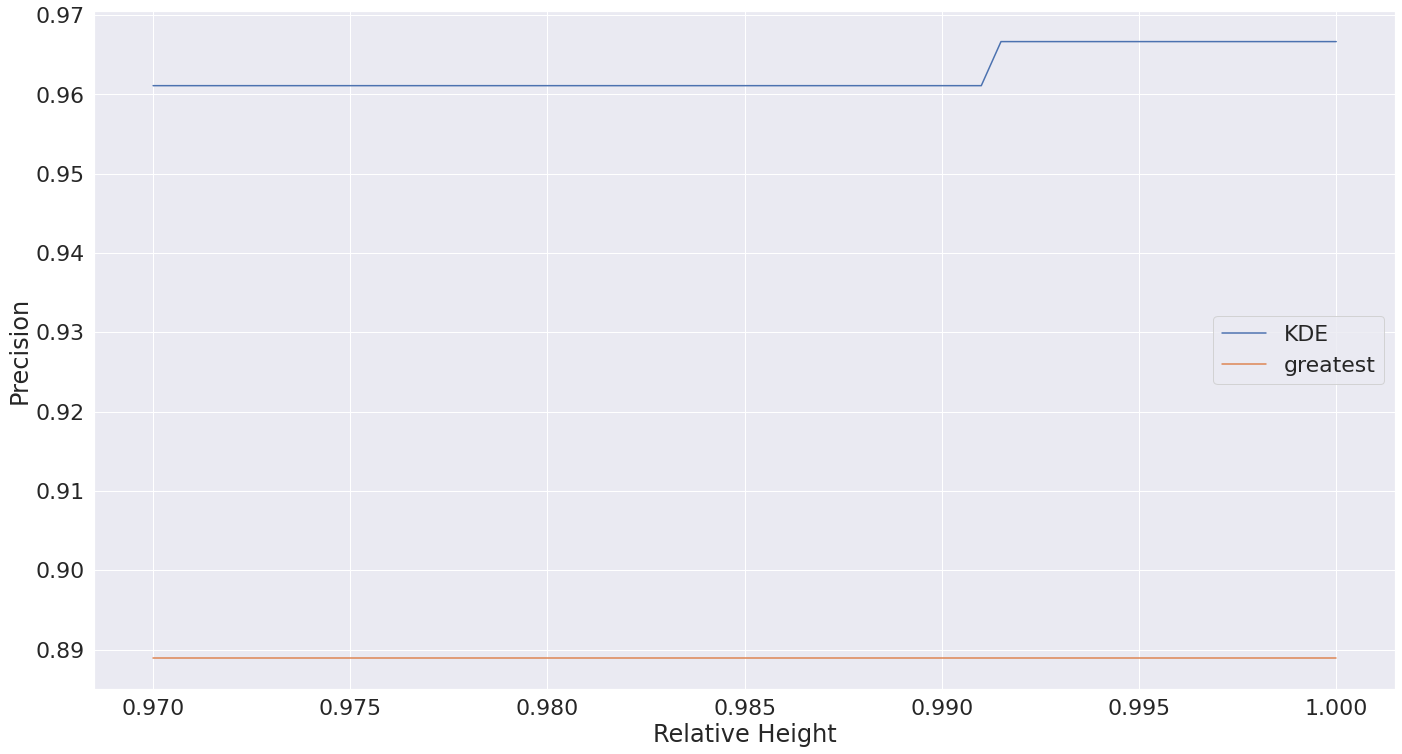

In [88]:
plt.plot(rel_height_to_precision_df['rel_height'], rel_height_to_precision_df['precision_kde'], label='KDE')
plt.plot(rel_height_to_precision_df['rel_height'], rel_height_to_precision_df['precision_greatest'], label='greatest')
plt.legend();plt.ylabel('Precision');plt.xlabel('Relative Height');plt.tight_layout()
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/rel_height_precision.svg')

# Jaccard Similarity (Synthetic Dataset with Nulls)

In [206]:
df_path = '../../output/synthetic_example_large_with_nulls/'
g_path = '../../../graph_construction/combined_graphs_output/synthetic_benchmark_large_with_nulls/bipartite/bipartite.graph'
input_nodes_json_path = '../../input/synthetic_large_with_nulls/input_nodes.json'
matrices_path = df_path + 'num_meanings/jaccard/matrices/'

df = pd.read_pickle(df_path + 'graph_stats_with_groundtruth_df.pickle')
G = pickle.load(open(g_path, "rb"))

with open(input_nodes_json_path) as f:
  input_nodes = json.load(f)['input_nodes']

# Remove nodes with degree 1 from the dataframe
df = stp.process_df(df, G)

# Compute the groundtruth for the number of meanings for each homograph
df = utils.num_meanings.get_num_meanings_groundtruth(df, G)
df_homs = df[df['is_homograph']==True].sort_values(by='betweenness_centrality', ascending=False)
df_homs

100%|██████████| 183/183 [00:00<00:00, 3277.64it/s]

There are 6503 cell nodes with a degree greater than 1
There are 614 unique ranks based on BC.


,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
70,missing,cell,1.611175e-01,True,1.0,17
2059,unknown,cell,1.244477e-01,True,2.0,11
2815,undefined,cell,1.045398e-02,True,3.0,8
723,Jamaica,cell,3.296411e-03,True,4.0,2
7589,Palm,cell,3.005904e-03,True,5.0,2
...,...,...,...,...,...,...
27428,Comanche,cell,1.487889e-05,True,213.0,2
2004,ME,cell,1.108179e-05,True,219.0,2
1959,California,cell,5.439775e-06,True,267.0,2
1945,LA,cell,5.320422e-06,True,272.0,2


In [207]:
df_homs[df_homs['num_meanings_groundtruth'] > 2]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
70,missing,cell,0.161117,True,1.0,17
2059,unknown,cell,0.124448,True,2.0,11
2815,undefined,cell,0.010454,True,3.0,8
546,Virginia,cell,0.000858,True,27.0,3
300,Lincoln,cell,0.000701,True,37.0,3
1401,Aurora,cell,0.000379,True,60.0,3
2012,Montana,cell,0.000299,True,79.0,3


In [208]:
# Map each input node from tje json file to its pairwise distance matrix and its index to node dictionary
node_to_matrix_dict = {}
node_to_idx_dict = {}
for node in input_nodes:
    # We subtract the matrix from one to convert it from a similarity matrix to a distance matrix
    m = 1 - np.load(matrices_path + node + '.npy')
    idx_to_node = pickle.load(open(matrices_path + node + '_idx_to_node.pickle', 'rb'))

    node_to_matrix_dict[node] = m
    node_to_idx_dict[node] = idx_to_node

In [209]:
df_input_nodes = df.copy()[df['node'].isin(input_nodes)]
df_input_nodes, labels_greatest, labels_kde = get_num_meanings(df_input_nodes, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=1000, rel_height=0.999, bandwidth_multiplier=20, dynamic_num_samples=True, log_base=2)
df_input_nodes = run_cluster_evaluation_df(df_input_nodes, G, labels_greatest, labels_kde, node_to_idx_dict)

In [210]:
df_input_nodes[df_input_nodes['is_trivial_prediction']==False].mean()

betweenness_centrality                0.003234
is_homograph                          1.000000
dense_rank                          113.504762
num_meanings_groundtruth              2.323810
num_meanings_greatest                 2.133333
num_meanings_kde                      2.438095
epsilon_greatest                      0.651961
epsilon_kde                           0.593227
is_trivial_prediction                 0.000000
is_kde_num_meanings_correct           0.933333
is_greatest_num_meanings_correct      0.790476
greatest_adj_rand_index               0.796718
greatest_adj_mutual_info              0.797781
greatest_norm_mutual_info             0.799326
kde_adj_rand_index                    0.982686
kde_adj_mutual_info                   0.981866
kde_norm_mutual_info                  0.990858
dtype: float64

In [211]:
print('Greatest distribution:', df_input_nodes['is_greatest_num_meanings_correct'].value_counts())
print('KDE distribution:', df_input_nodes['is_kde_num_meanings_correct'].value_counts())

Greatest distribution: True     161
False     22
Name: is_greatest_num_meanings_correct, dtype: int64
KDE distribution: True     176
False      7
Name: is_kde_num_meanings_correct, dtype: int64


In [212]:
df_input_nodes[df_input_nodes['is_kde_num_meanings_correct'] == False]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct,greatest_adj_rand_index,greatest_adj_mutual_info,greatest_norm_mutual_info,kde_adj_rand_index,kde_adj_mutual_info,kde_norm_mutual_info
70,missing,cell,0.161117,True,1.0,17,17.0,22.0,0.989247,0.868019,False,False,True,0.672434,0.797247,0.941237,0.813860,0.807411,0.957434
2059,unknown,cell,0.124448,True,2.0,11,12.0,13.0,0.969828,0.701670,False,False,False,0.982906,0.969728,0.987995,0.965341,0.937960,0.976274
723,Jamaica,cell,0.003296,True,4.0,2,2.0,3.0,0.980365,0.488379,False,False,True,1.000000,1.000000,1.000000,0.974766,0.878654,0.894711
590,Brooklyn,cell,0.001276,True,17.0,2,2.0,3.0,0.982627,0.594014,False,False,True,1.000000,1.000000,1.000000,0.333333,0.420620,0.702017
1174,Chicago,cell,0.000921,True,24.0,2,2.0,3.0,0.978534,0.593997,False,False,True,1.000000,1.000000,1.000000,0.571429,0.571429,0.800000
300,Lincoln,cell,0.000701,True,37.0,3,3.0,4.0,0.982627,0.623266,False,False,True,1.000000,1.000000,1.000000,0.740741,0.767236,0.880421
18611,Kansas,cell,0.000234,True,94.0,2,2.0,3.0,0.978534,0.203794,False,False,True,1.000000,1.000000,1.000000,0.782609,0.712594,0.829199


## Number of Samples Experiment

In [96]:
samples_to_df_dict = {}

for samples in tqdm(range(200, 10000, 100)):
    df_tmp = df.copy()[df['node'].isin(input_nodes)]
    df_tmp = get_num_meanings(df_tmp, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=samples, rel_height=0.999, bandwidth_multiplier=20)
    samples_to_df_dict[samples] = df_tmp

100%|██████████| 98/98 [01:14<00:00,  1.32it/s]


In [101]:
samples_to_precision_dict = {'samples': [], 'precision_kde': [], 'precision_greatest': []}
for num_samples, df_tmp in samples_to_df_dict.items():
    precision_kde = df_tmp['is_kde_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
    precision_greatest = df_tmp['is_greatest_num_meanings_correct'].value_counts()[True] / len(df_tmp.index)
    samples_to_precision_dict['samples'].append(num_samples)
    samples_to_precision_dict['precision_kde'].append(precision_kde)
    samples_to_precision_dict['precision_greatest'].append(precision_greatest)

samples_to_precision_df = pd.DataFrame.from_dict(samples_to_precision_dict)
samples_to_precision_df.head()

,samples,precision_kde,precision_greatest
0,200,0.934426,0.879781
1,300,0.950820,0.879781
2,400,0.950820,0.879781
3,500,0.950820,0.879781
4,600,0.950820,0.879781


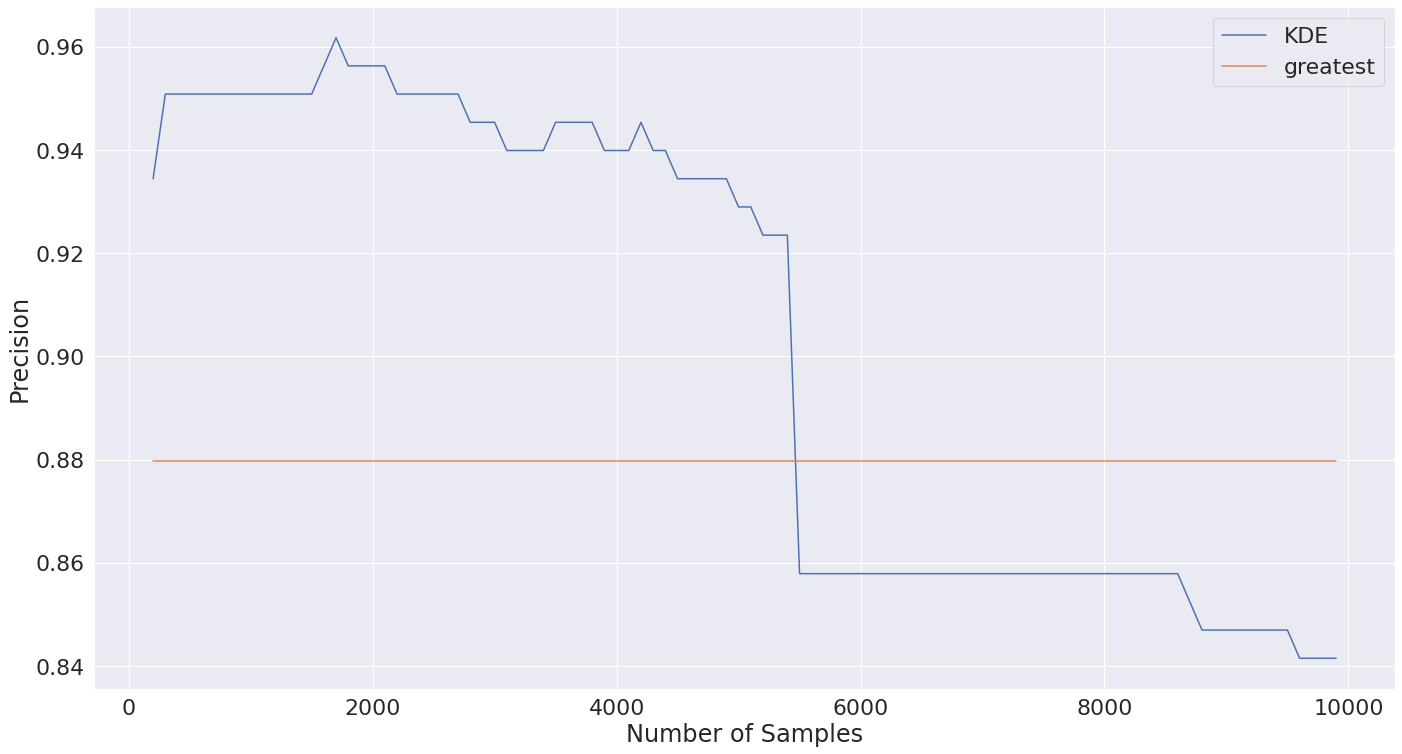

In [102]:
plt.plot(samples_to_precision_df['samples'], samples_to_precision_df['precision_kde'], label='KDE')
plt.plot(samples_to_precision_df['samples'], samples_to_precision_df['precision_greatest'], label='greatest')
plt.legend();plt.ylabel('Precision');plt.xlabel('Number of Samples');plt.tight_layout()
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark_with_nulls/num_samples_precision.svg')

# Jaccard Similarity (Large2 Synthetic)

In [215]:
df_path = '../../output/synthetic_example_large2/'
g_path = '../../../graph_construction/combined_graphs_output/synthetic_benchmark_large2/bipartite/bipartite.graph'
input_nodes_json_path = '../../input/synthetic_large2/input_nodes.json'
matrices_path = df_path + 'num_meanings/jaccard/matrices/'

df = pd.read_pickle(df_path + 'graph_stats_df.pickle')
G = pickle.load(open(g_path, "rb"))

# Add the is_homograph column
df['is_homograph'] = np.nan
is_homograph_map = {}
for node in df[df['node_type']=='cell']['node']:
    is_homograph_map[node] = utils.groundtruth.is_cur_node_homograph(G, node)
df['is_homograph'] = df['node'].map(is_homograph_map)

df.to_pickle(df_path+'graph_stats_with_groundtruth_df.pickle')

with open(input_nodes_json_path) as f:
  input_nodes = json.load(f)['input_nodes']

# Remove nodes with degree 1 from the dataframe
df = stp.process_df(df, G)

# Compute the groundtruth for the number of meanings for each homograph
df = utils.num_meanings.get_num_meanings_groundtruth(df, G)
df['degree'] = np.nan
for node in input_nodes:
  df.loc[df['node']==node, 'degree'] = G.degree[node]
  
df_homs = df[df['is_homograph'] == True].sort_values(by='betweenness_centrality', ascending=False)
df_homs

 48%|████▊     | 370/775 [00:00<00:00, 3690.38it/s]

There are 27497 cell nodes with a degree greater than 1
There are 10437 unique ranks based on BC.


100%|██████████| 775/775 [00:00<00:00, 3801.15it/s]


,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,degree
84683,Ironweed,cell,2.857781e-03,True,1.0,2,5.0
4142,Mesquite,cell,2.600531e-03,True,2.0,2,10.0
29359,Clementine,cell,2.183925e-03,True,3.0,2,9.0
21631,Birch,cell,2.140734e-03,True,4.0,2,8.0
17405,Timothy,cell,1.918734e-03,True,5.0,3,6.0
...,...,...,...,...,...,...,...
3474,GA,cell,3.188423e-08,True,6629.0,2,19.0
2776,ME,cell,1.499255e-08,True,7088.0,2,19.0
17034,KY,cell,1.000974e-08,True,7610.0,2,13.0
3626,MS,cell,8.243552e-09,True,7915.0,2,12.0


In [216]:
print('There are', len(df[df['is_homograph']==True]), 'homographs based on the groundtruth')
json.dumps(df[df['is_homograph']==True]['node'].tolist())

There are 775 homographs based on the groundtruth


'["Ironweed", "Mesquite", "Clementine", "Birch", "Timothy", "Mara", "Southern Comfort", "Cordia", "War", "Cougar", "Camellia", "Mace", "Palm", "Viva", "Western", "Heath", "Pepper", "Olive", "Jaguar", "Bahia", "Stock", "Mandrake", "Impala", "Lotus", "Lavender", "Rudy", "Inga", "Mulberry", "Spurge", "Cappel", "Corn", "Holly", "Dill", "Daphne", "Heather", "Lily", "Jerusalem Artichoke", "Lucas", "Willow", "Dahlia", "Yarrow", "Scarface", "Don", "Hyacinth", "Lucy", "Watercress", "Cinnamon", "Petunia", "Elizabeth", "Mercy", "Parsley", "Brooklyn", "Rice", "Dagon", "Avocado", "Charleston", "August", "Saba", "Constantine", "Pren", "Angus", "Honey", "Dust", "Bella", "Merlin", "Faust", "Avalon", "Saw", "Bethlehem", "Chard", "Camille", "ES", "Radish", "Joe", "Jordan", "Eugenia", "Chad", "Ray", "Absolon", "Jojo", "Cornelis", "Brave", "Camila", "Calendar", "Ariel", "Wake", "Chicago", "Montana", "Yucca", "Cinderella", "Hew", "Rampage", "Shane", "Red", "Miranda", "Edge", "Lincoln", "Coronado", "Quest",

In [217]:
df_homs[df_homs['num_meanings_groundtruth'] > 2]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,degree
17405,Timothy,cell,0.001919,True,5.0,3,6.0
20873,Lucas,cell,0.000453,True,38.0,3,5.0
28008,Lucy,cell,0.000354,True,45.0,3,5.0
29229,Elizabeth,cell,0.000331,True,49.0,3,4.0
26380,Mercy,cell,0.000321,True,50.0,3,4.0
28068,Constantine,cell,0.000286,True,60.0,3,4.0
4408,Angus,cell,0.000262,True,64.0,4,9.0
22015,Joe,cell,0.000226,True,78.0,3,4.0
2212,Chad,cell,0.000222,True,81.0,3,39.0
2981,Montana,cell,0.000200,True,95.0,3,28.0


In [218]:
# Map each input node from tje json file to its pairwise distance matrix and its index to node dictionary
node_to_matrix_dict = {}
node_to_idx_dict = {}
for node in input_nodes:
    # We subtract the matrix from one to convert it from a similarity matrix to a distance matrix
    m = 1 - np.load(matrices_path + node + '.npy')
    idx_to_node = pickle.load(open(matrices_path + node + '_idx_to_node.pickle', 'rb'))

    node_to_matrix_dict[node] = m
    node_to_idx_dict[node] = idx_to_node

In [219]:
df_input_nodes = df.copy()[df['node'].isin(input_nodes)]
df_input_nodes, labels_greatest, labels_kde = get_num_meanings(df_input_nodes, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=2000, rel_height=0.999, bandwidth_multiplier=20, dynamic_num_samples=True, log_base=10)
df_input_nodes

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,degree,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct
84683,Ironweed,cell,2.857781e-03,True,1.0,2,5.0,2.0,2.0,0.971551,0.975585,False,True,True
4142,Mesquite,cell,2.600531e-03,True,2.0,2,10.0,2.0,2.0,0.974839,0.981781,False,True,True
29359,Clementine,cell,2.183925e-03,True,3.0,2,9.0,2.0,2.0,0.940349,0.955294,False,True,True
21631,Birch,cell,2.140734e-03,True,4.0,2,8.0,2.0,2.0,0.974359,0.978921,False,True,True
17405,Timothy,cell,1.918734e-03,True,5.0,3,6.0,4.0,3.0,0.972625,0.992946,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,GA,cell,3.188423e-08,True,6629.0,2,19.0,1.0,2.0,0.950704,0.476133,False,True,False
2776,ME,cell,1.499255e-08,True,7088.0,2,19.0,1.0,2.0,0.928571,0.462781,False,True,False
17034,KY,cell,1.000974e-08,True,7610.0,2,13.0,1.0,2.0,0.928105,0.371445,False,True,False
3626,MS,cell,8.243552e-09,True,7915.0,2,12.0,1.0,2.0,0.932886,0.417751,False,True,False


In [220]:
df_input_nodes = run_cluster_evaluation_df(df_input_nodes, G, labels_greatest, labels_kde, node_to_idx_dict)
df_input_nodes

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,degree,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct,greatest_adj_rand_index,greatest_adj_mutual_info,greatest_norm_mutual_info,kde_adj_rand_index,kde_adj_mutual_info,kde_norm_mutual_info
84683,Ironweed,cell,2.857781e-03,True,1.0,2,5.0,2.0,2.0,0.971551,0.975585,False,True,True,1.000000,1.000000e+00,1.000000e+00,1.0,1.0,1.0
4142,Mesquite,cell,2.600531e-03,True,2.0,2,10.0,2.0,2.0,0.974839,0.981781,False,True,True,1.000000,1.000000e+00,1.000000e+00,1.0,1.0,1.0
29359,Clementine,cell,2.183925e-03,True,3.0,2,9.0,2.0,2.0,0.940349,0.955294,False,True,True,1.000000,1.000000e+00,1.000000e+00,1.0,1.0,1.0
21631,Birch,cell,2.140734e-03,True,4.0,2,8.0,2.0,2.0,0.974359,0.978921,False,True,True,1.000000,1.000000e+00,1.000000e+00,1.0,1.0,1.0
17405,Timothy,cell,1.918734e-03,True,5.0,3,6.0,4.0,3.0,0.972625,0.992946,False,True,False,0.761905,7.619048e-01,9.048505e-01,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,GA,cell,3.188423e-08,True,6629.0,2,19.0,1.0,2.0,0.950704,0.476133,False,True,False,0.000000,8.523724e-16,0.000000e+00,1.0,1.0,1.0
2776,ME,cell,1.499255e-08,True,7088.0,2,19.0,1.0,2.0,0.928571,0.462781,False,True,False,0.000000,0.000000e+00,0.000000e+00,1.0,1.0,1.0
17034,KY,cell,1.000974e-08,True,7610.0,2,13.0,1.0,2.0,0.928105,0.371445,False,True,False,0.000000,3.431404e-15,1.680890e-15,1.0,1.0,1.0
3626,MS,cell,8.243552e-09,True,7915.0,2,12.0,1.0,2.0,0.932886,0.417751,False,True,False,0.000000,3.948617e-16,0.000000e+00,1.0,1.0,1.0


In [221]:
print('Greatest distribution:', df_input_nodes['is_greatest_num_meanings_correct'].value_counts())
print('KDE distribution:', df_input_nodes['is_kde_num_meanings_correct'].value_counts())

Greatest distribution: True     734
False     41
Name: is_greatest_num_meanings_correct, dtype: int64
KDE distribution: True     739
False     36
Name: is_kde_num_meanings_correct, dtype: int64


In [222]:
df_input_nodes[(df_input_nodes['is_kde_num_meanings_correct'] == False) & df_input_nodes['is_greatest_num_meanings_correct'] == True]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,degree,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct,greatest_adj_rand_index,greatest_adj_mutual_info,greatest_norm_mutual_info,kde_adj_rand_index,kde_adj_mutual_info,kde_norm_mutual_info
80360,War,cell,0.001521,True,9.0,2,11.0,2.0,3.0,0.980198,0.702478,False,False,True,1.0,1.0,1.0,0.959289,8.568193e-01,0.882690
3865,Brooklyn,cell,0.000318,True,52.0,2,13.0,2.0,3.0,0.981818,0.613121,False,False,True,1.0,1.0,1.0,0.968775,8.696092e-01,0.889527
3786,Charleston,cell,0.000295,True,56.0,2,14.0,2.0,3.0,0.980115,0.612765,False,False,True,1.0,1.0,1.0,0.972077,8.744822e-01,0.892281
28068,Constantine,cell,0.000286,True,60.0,3,4.0,3.0,2.0,0.988776,0.997882,False,False,True,1.0,1.0,1.0,0.333333,4.206198e-01,0.702017
39587,Faust,cell,0.000243,True,69.0,2,3.0,2.0,1.0,0.984912,0.998947,False,False,True,1.0,1.0,1.0,0.000000,4.651263e-16,0.000000
2639,Avalon,cell,0.000241,True,70.0,2,14.0,2.0,3.0,0.984912,0.562006,False,False,True,1.0,1.0,1.0,0.972077,8.744822e-01,0.892281
4156,Bethlehem,cell,0.000235,True,72.0,2,8.0,2.0,3.0,0.983420,0.615798,False,False,True,1.0,1.0,1.0,0.927835,8.221638e-01,0.866493
2981,Montana,cell,0.000200,True,95.0,3,28.0,3.0,4.0,0.974710,0.882870,False,False,True,1.0,1.0,1.0,0.994626,9.687163e-01,0.972517
2567,Quest,cell,0.000180,True,108.0,2,14.0,2.0,3.0,0.979656,0.561992,False,False,True,1.0,1.0,1.0,0.972077,8.744822e-01,0.892281
27092,Jonas,cell,0.000179,True,109.0,3,3.0,3.0,2.0,0.010000,0.997610,False,False,True,1.0,1.0,1.0,0.000000,0.000000e+00,0.733680


In [243]:
node='Annapolis'
print(node_to_idx_dict[node])
print(node_to_matrix_dict[node])
print(utils.graph_helpers.get_cell_node_column_names(G, node))

{0: 'city_city_country_2.csv', 1: 'city_city_country_8.csv', 2: 'city_city_country_9.csv', 3: 'movie_title_movie_title_movie_genre_country_code_10.csv', 4: 'movie_title_movie_title_movie_genre_country_code_4.csv'}
[[0.         0.56547619 0.55473373 0.99862164 0.99794661]
 [0.56547619 0.         0.56661786 0.99862354 0.99657769]
 [0.55473373 0.56661786 0.         0.99863574 0.99728814]
 [0.99862164 0.99862354 0.99863574 0.         0.97697541]
 [0.99794661 0.99657769 0.99728814 0.97697541 0.        ]]
['movie_title', 'city']


Using: 1571 samples
Widths: [0.05995478 0.06800012] Width Lengths: [0.01351941 0.03511156] Peak left boundaries: [0.53107469 0.95498329] Peak right boundaries: [0.59102947 1.02298341]
Epsilon: 0.5976057973628774
Labels [0 0 0 1 2]


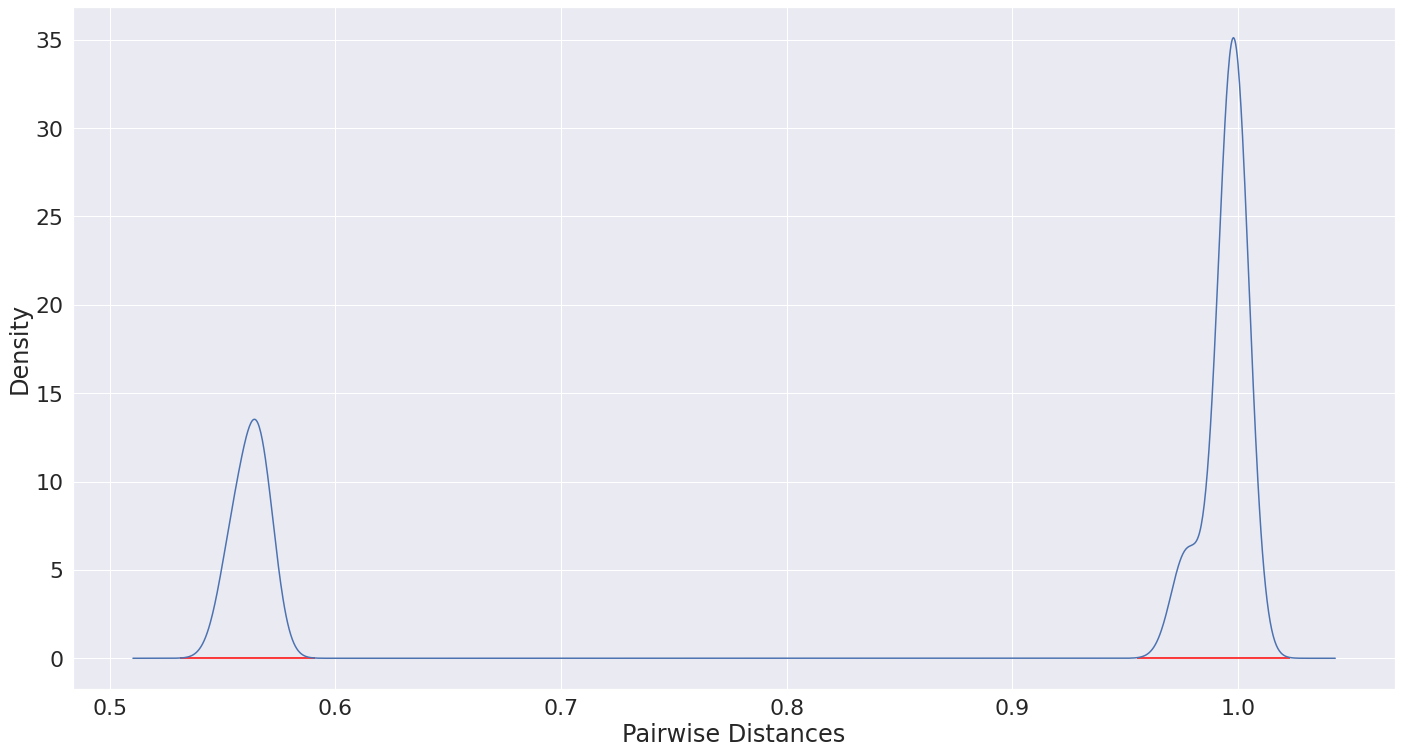

In [244]:
f = plt.figure()
f = get_density_fig_for_node(node, fig=f, node_to_matrix_dict=node_to_matrix_dict, num_samples=2000, boundary_proportion=0.1, bandwidth_multiplier=20, dynamic_num_samples=True, log_base=10, rel_height=0.999)
f.savefig('../../figures/num_meanings/clustering/synthetic_benchmark_large2/Annapolis.svg')

Using: 1571 samples
Widths: [0.05995478 0.06800012] Width Lengths: [0.01351941 0.03511156] Peak left boundaries: [0.53107469 0.95498329] Peak right boundaries: [0.59102947 1.02298341]
Epsilon: 0.5910294714019256
Labels [0 0 0 1 2]


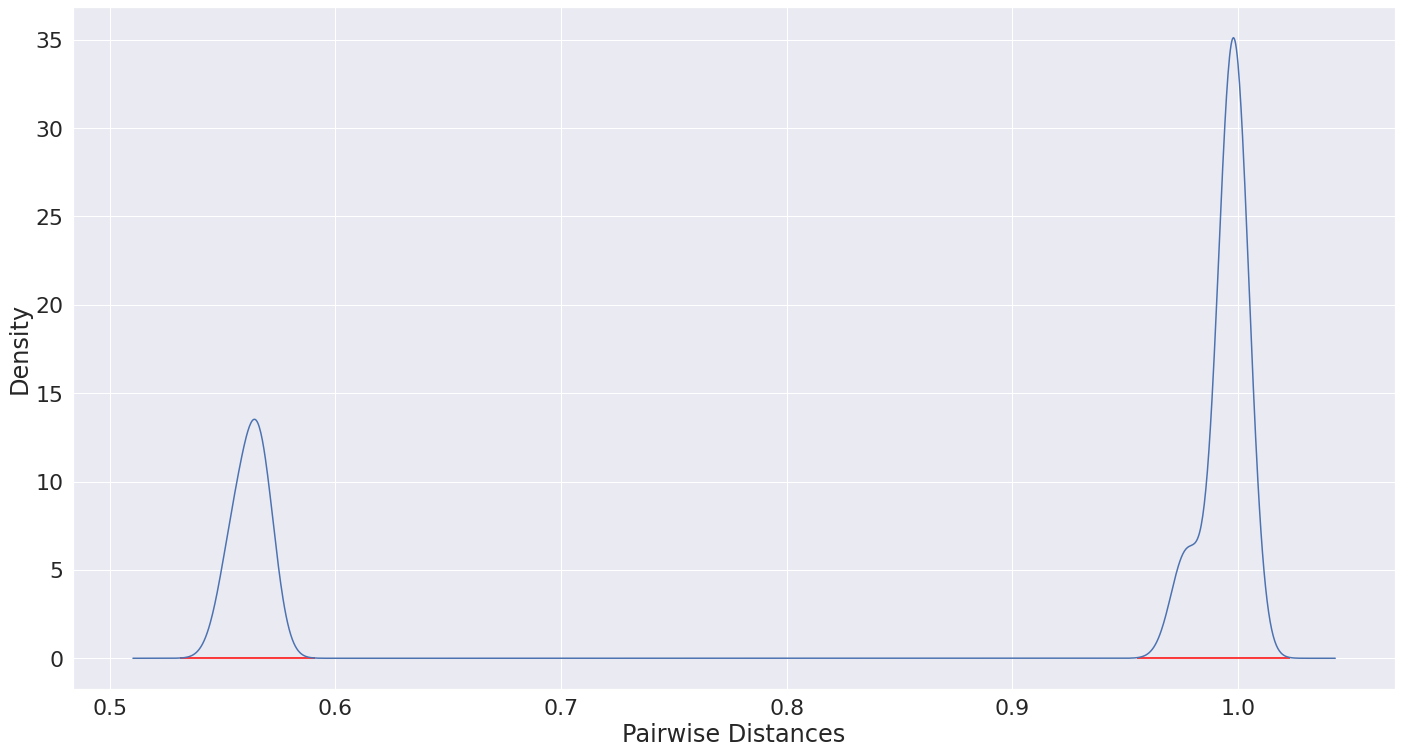

In [224]:
vals = get_vals_in_range(node_to_matrix_dict[node], lower_bound=0, upper_bound=1)
num_samples = 2000
density, samples, samples_lower_bnd, samples_upper_bnd = get_kde(vals, bandwidth_multiplier=20, num_samples=num_samples, boundary_proportion=0.1, dynamic_num_samples=True)
print('Using:', len(samples), 'samples')
widths, width_heights, left_pos, right_pos = get_peak_widths(density, samples_lower_bnd, samples_upper_bnd, num_samples=len(samples), rel_height=0.999)
print('Widths:', widths, 'Width Lengths:', width_heights, 'Peak left boundaries:', left_pos, 'Peak right boundaries:', right_pos)

epsilon = get_epsilon(node_to_matrix_dict[node], lower_bound=0, upper_bound=1, mode='kde', num_samples=len(samples), rel_height=0.999, bandwidth_multiplier=20)
print('Epsilon:', epsilon)

labels = DBSCAN(min_samples=1, metric='precomputed', eps=epsilon).fit_predict(node_to_matrix_dict[node])
print("Labels", labels)

plt.plot(samples, density)
plt.hlines(y=width_heights, xmin=left_pos, xmax=right_pos, colors='red')
plt.ylabel('Density');plt.xlabel('Pairwise Distances');plt.tight_layout()

In [131]:
df_input_nodes[df_input_nodes['is_trivial_prediction']==False].mean()

betweenness_centrality                0.000144
is_homograph                          1.000000
dense_rank                          713.564246
num_meanings_groundtruth              2.059590
degree                                8.945996
num_meanings_greatest                 2.020484
num_meanings_kde                      2.094972
epsilon_greatest                      0.820048
epsilon_kde                           0.810523
is_trivial_prediction                 0.000000
is_kde_num_meanings_correct           0.903166
is_greatest_num_meanings_correct      0.923650
greatest_adj_rand_index               0.933020
greatest_adj_mutual_info              0.932798
greatest_norm_mutual_info             0.939925
kde_adj_rand_index                    0.954072
kde_adj_mutual_info                   0.949593
kde_norm_mutual_info                  0.956485
dtype: float64

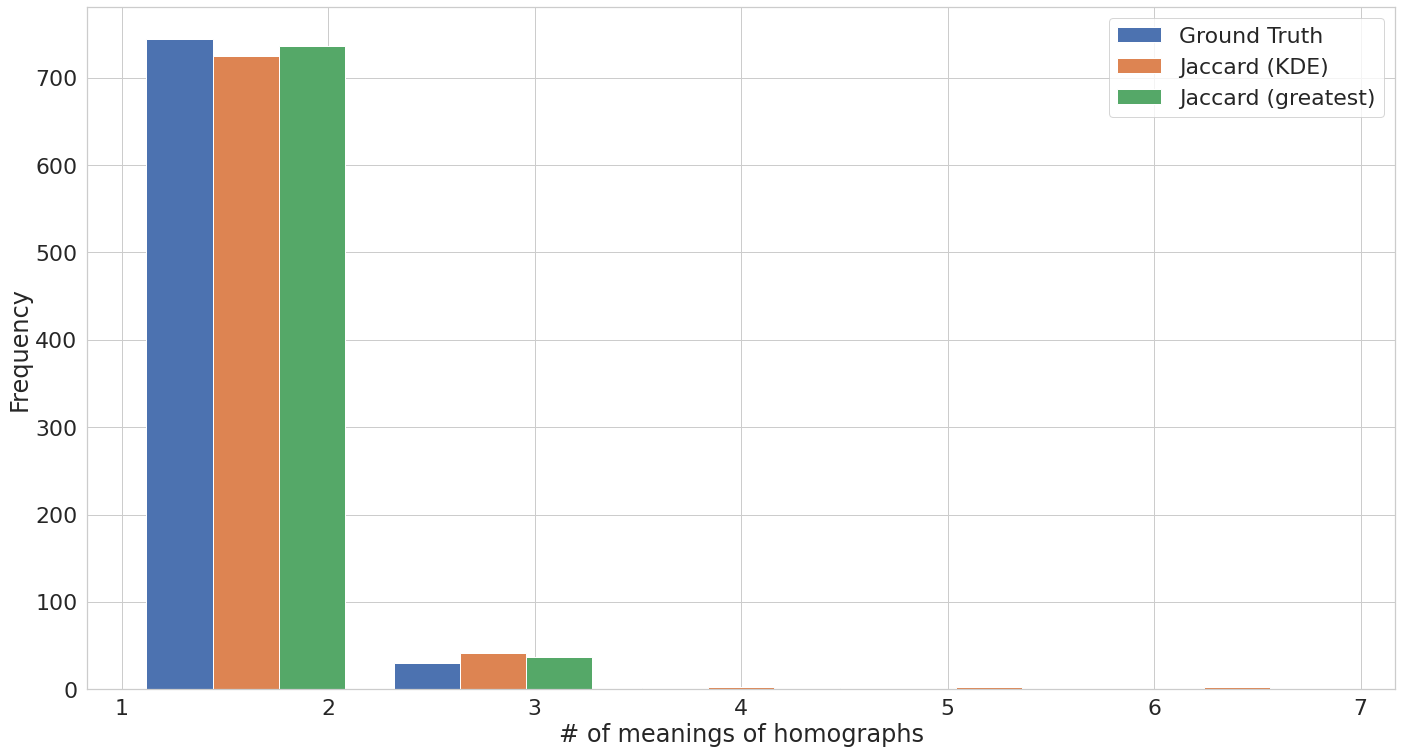

In [132]:
ax = plt.hist([df_input_nodes['num_meanings_groundtruth'], df_input_nodes['num_meanings_kde'], df_input_nodes['num_meanings_greatest']], bins=5, label=['Ground Truth', 'Jaccard (KDE)', 'Jaccard (greatest)'])
plt.xlabel('# of meanings of homographs');plt.ylabel('Frequency');plt.legend();plt.tight_layout()
# plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/num_meanings_histogram.svg')

# Unionability (Synthetic Dataset)

In [63]:
df_path = '../../output/synthetic_example_large/'
g_path = '../../../graph_construction/combined_graphs_output/synthetic_benchmark_large/bipartite/bipartite.graph'
input_nodes_json_path = '../../input/synthetic_large/input_nodes.json'
matrices_path = df_path + 'num_meanings/unionability/matrices/'

df = pd.read_pickle(df_path + 'graph_stats_with_groundtruth_df.pickle')
G = pickle.load(open(g_path, "rb"))

with open(input_nodes_json_path) as f:
  input_nodes = json.load(f)['input_nodes']

# Remove nodes with degree 1 from the dataframe
df = stp.process_df(df, G)

# Compute the groundtruth for the number of meanings for each homograph
df = utils.num_meanings.get_num_meanings_groundtruth(df, G)
df_homs = df[df['is_homograph']==True].sort_values(by='betweenness_centrality', ascending=False)
df_homs

100%|██████████| 180/180 [00:00<00:00, 3834.71it/s]

There are 6502 cell nodes with a degree greater than 1
There are 611 unique ranks based on BC.


,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
7590,Palm,cell,1.445700e-02,True,1.0,2
25825,Clementine,cell,8.975958e-03,True,2.0,2
7130,Magnolia,cell,8.132084e-03,True,3.0,2
3077,Jaguar,cell,8.049376e-03,True,4.0,2
7416,Timothy,cell,6.921700e-03,True,5.0,2
...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2
1828,SD,cell,2.059766e-07,True,276.0,2
2004,ME,cell,1.214843e-07,True,314.0,2
1950,NC,cell,7.969017e-08,True,329.0,2


In [134]:
# Map each input node from tje json file to its pairwise distance matrix and its index to node dictionary
node_to_matrix_dict = {}
node_to_idx_dict = {}
for node in input_nodes:
    # We subtract the matrix from one to convert it from a similarity matrix to a distance matrix
    m = 1 - np.load(matrices_path + node + '.npy')
    idx_to_node = pickle.load(open(matrices_path + node + '_idx_to_node.pickle', 'rb'))

    node_to_matrix_dict[node] = m
    node_to_idx_dict[node] = idx_to_node

In [135]:
df_input_nodes = df.copy()[df['node'].isin(input_nodes)]
df_input_nodes, labels_greatest, labels_kde = get_num_meanings(df_input_nodes, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=1000, rel_height=0.999, bandwidth_multiplier=20)
df_input_nodes = run_cluster_evaluation_df(df_input_nodes, G, labels_greatest, labels_kde, node_to_idx_dict)
df_input_nodes

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct,greatest_adj_rand_index,greatest_adj_mutual_info,greatest_norm_mutual_info,kde_adj_rand_index,kde_adj_mutual_info,kde_norm_mutual_info
7590,Palm,cell,1.445700e-02,True,1.0,2,1.0,1.0,0.833333,0.544343,False,False,False,0.0,0.000000e+00,0.00000,0.0,0.000000e+00,0.00000
25825,Clementine,cell,8.975958e-03,True,2.0,2,2.0,2.0,0.010000,0.500000,False,True,True,1.0,1.000000e+00,1.00000,1.0,1.000000e+00,1.00000
7130,Magnolia,cell,8.132084e-03,True,3.0,2,2.0,2.0,NaN,NaN,True,True,True,1.0,0.000000e+00,1.00000,1.0,0.000000e+00,1.00000
3077,Jaguar,cell,8.049376e-03,True,4.0,2,1.0,1.0,0.933333,0.803534,False,False,False,0.0,6.406853e-16,0.00000,0.0,6.406853e-16,0.00000
7416,Timothy,cell,6.921700e-03,True,5.0,2,2.0,2.0,NaN,NaN,True,True,True,1.0,0.000000e+00,1.00000,1.0,0.000000e+00,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2,6.0,6.0,0.010000,0.500000,False,False,False,0.0,6.622275e-16,0.40187,0.0,6.622275e-16,0.40187
1828,SD,cell,2.059766e-07,True,276.0,2,6.0,6.0,0.010000,0.500000,False,False,False,0.0,6.622275e-16,0.40187,0.0,6.622275e-16,0.40187
2004,ME,cell,1.214843e-07,True,314.0,2,4.0,4.0,0.010000,0.500000,False,False,False,0.0,2.694849e-16,0.57716,0.0,2.694849e-16,0.57716
1950,NC,cell,7.969017e-08,True,329.0,2,3.0,3.0,0.010000,0.500000,False,False,False,0.0,4.805140e-16,0.73368,0.0,4.805140e-16,0.73368


In [136]:
print('Greatest distribution:', df_input_nodes['is_greatest_num_meanings_correct'].value_counts())
print('KDE distribution:', df_input_nodes['is_kde_num_meanings_correct'].value_counts())

Greatest distribution: True     96
False    84
Name: is_greatest_num_meanings_correct, dtype: int64
KDE distribution: True     101
False     79
Name: is_kde_num_meanings_correct, dtype: int64


In [137]:
df_input_nodes[df_input_nodes['is_trivial_prediction'] == False].mean()

betweenness_centrality                0.000992
is_homograph                          1.000000
dense_rank                          106.107843
num_meanings_groundtruth              2.039216
num_meanings_greatest                 3.460784
num_meanings_kde                      3.833333
epsilon_greatest                      0.352978
epsilon_kde                           0.569448
is_trivial_prediction                 0.000000
is_kde_num_meanings_correct           0.225490
is_greatest_num_meanings_correct      0.176471
greatest_adj_rand_index               0.068805
greatest_adj_mutual_info              0.066536
greatest_norm_mutual_info             0.341354
kde_adj_rand_index                    0.155057
kde_adj_mutual_info                   0.150644
kde_norm_mutual_info                  0.518757
dtype: float64

# Jaccard Similarity (D4-Education) 

In [73]:
df_path = '../../output/D4-Education/'
g_path = '../../../graph_construction/combined_graphs_output/D4-Education/bipartite/bipartite.graph'
input_nodes_json_path = '../../input/D4-Education/input_nodes.json'
matrices_path = df_path + 'num_meanings/jaccard/matrices/'

df = pd.read_pickle(df_path + 'graph_stats_df.pickle')
G = pickle.load(open(g_path, "rb"))

# with open(input_nodes_json_path) as f:
#   input_nodes = json.load(f)['input_nodes']

# Remove nodes with degree 1 from the dataframe
df = stp.process_df(df, G).sort_values(by='betweenness_centrality', ascending=False).head(100)
df['is_homograph']=True

# Compute the groundtruth for the number of meanings for each homograph (Assumption: Highest 100 BC values are homographs)
df = utils.num_meanings.get_num_meanings_groundtruth(df, G)
df = df[df['num_meanings_groundtruth']>1]
df.to_pickle('../../output/D4-Education/graph_stats_with_groundtruth_df.pickle')
df

100%|██████████| 100/100 [00:00<00:00, 3102.16it/s]

There are 143872 cell nodes with a degree greater than 1
There are 22173 unique ranks based on BC.


,node,node_type,betweenness_centrality,dense_rank,is_homograph,num_meanings_groundtruth
66,4,cell,162.035386,1.0,True,144
28,3,cell,77.844007,2.0,True,137
9353,0,cell,77.277890,3.0,True,169
130,6,cell,67.565816,4.0,True,137
96,5,cell,66.728263,5.0,True,134
...,...,...,...,...,...,...
65660,P.S. 20,cell,0.996840,84.0,True,3
253669,1237502,cell,0.942315,85.0,True,2
192451,1262304,cell,0.942315,85.0,True,2
176027,1255913,cell,0.942315,85.0,True,2


In [74]:
# Remove numeric value nodes and values with large determined number of meanings
max_num_meanings=5
valid_indices=[]
for idx, row in df.iterrows():
    if not row['node'].isnumeric() and row['num_meanings_groundtruth']<=max_num_meanings:
        valid_indices.append(idx)
valid_indices.remove(1407240);valid_indices.remove(1404866);valid_indices.remove(1394836)
df = df.loc[valid_indices]
df

,node,node_type,betweenness_centrality,dense_rank,is_homograph,num_meanings_groundtruth
45335,Chemistry,cell,10.858448,14.0,True,4
37275,--,cell,5.823986,20.0,True,3
62626,Early College,cell,5.688750,21.0,True,5
1062913,166 ESSEX STREET,cell,5.050365,23.0,True,3
1396771,Please contact the school for more information.,cell,4.919300,24.0,True,4
879122,CEDAR STREET,cell,3.471863,32.0,True,2
426115,EDGEWOOD AVENUE,cell,3.471863,32.0,True,2
634170,"CUSHMAN & WAKEFIELD, INC.",cell,2.972433,33.0,True,2
963488,26 COURT STREET,cell,2.902326,34.0,True,2
54531,Kelly,cell,2.867587,35.0,True,2


In [42]:
input_nodes = {'input_nodes': df['node'].tolist()}
with open('../../input/D4-Education/input_nodes.json', 'w') as fp:
    json.dump(input_nodes, fp)

In [51]:
# Map each input node from tje json file to its pairwise distance matrix and its index to node dictionary
node_to_matrix_dict = {}
node_to_idx_dict = {}
for node in input_nodes['input_nodes']:
    # We subtract the matrix from one to convert it from a similarity matrix to a distance matrix
    m = 1 - np.load(matrices_path + node + '.npy')
    idx_to_node = pickle.load(open(matrices_path + node + '_idx_to_node.pickle', 'rb'))

    node_to_matrix_dict[node] = m
    node_to_idx_dict[node] = idx_to_node

In [60]:
df_input_nodes = df.copy()[df['node'].isin(input_nodes['input_nodes'])]
df_input_nodes, labels_greatest, labels_kde = get_num_meanings(df_input_nodes, G, node_to_matrix_dict, lower_bound=0, upper_bound=1, num_samples=1000, rel_height=0.999, bandwidth_multiplier=20, dynamic_num_samples=False, log_base=2)
df_input_nodes = run_cluster_evaluation_df(df_input_nodes, G, labels_greatest, labels_kde, node_to_idx_dict, input_nodes=input_nodes['input_nodes'])
df_input_nodes

,node,node_type,betweenness_centrality,dense_rank,is_homograph,num_meanings_groundtruth,num_meanings_greatest,num_meanings_kde,epsilon_greatest,epsilon_kde,is_trivial_prediction,is_kde_num_meanings_correct,is_greatest_num_meanings_correct,greatest_adj_rand_index,greatest_adj_mutual_info,greatest_norm_mutual_info,kde_adj_rand_index,kde_adj_mutual_info,kde_norm_mutual_info
45335,Chemistry,cell,10.858448,14.0,True,4,2.0,2.0,0.987654,0.990467,False,False,False,0.299065,4.155844e-01,0.647464,0.299065,4.155844e-01,0.647464
37275,--,cell,5.823986,20.0,True,3,3.0,2.0,0.010000,0.999456,False,False,True,1.000000,1.000000e+00,1.000000,0.000000,0.000000e+00,0.733680
62626,Early College,cell,5.688750,21.0,True,5,3.0,5.0,0.984441,0.915631,False,True,False,0.571429,6.391132e-01,0.794280,0.531250,6.021292e-01,0.840208
1062913,166 ESSEX STREET,cell,5.050365,23.0,True,3,2.0,2.0,0.825036,0.840434,False,False,False,0.000000,0.000000e+00,0.733680,0.000000,0.000000e+00,0.733680
1396771,Please contact the school for more information.,cell,4.919300,24.0,True,4,4.0,1.0,0.010000,0.998353,False,False,True,1.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000
879122,CEDAR STREET,cell,3.471863,32.0,True,2,2.0,2.0,NaN,NaN,True,True,True,1.000000,0.000000e+00,1.000000,1.000000,0.000000e+00,1.000000
426115,EDGEWOOD AVENUE,cell,3.471863,32.0,True,2,2.0,2.0,NaN,NaN,True,True,True,1.000000,0.000000e+00,1.000000,1.000000,0.000000e+00,1.000000
634170,"CUSHMAN & WAKEFIELD, INC.",cell,2.972433,33.0,True,2,2.0,2.0,NaN,NaN,True,True,True,1.000000,0.000000e+00,1.000000,1.000000,0.000000e+00,1.000000
963488,26 COURT STREET,cell,2.902326,34.0,True,2,2.0,2.0,NaN,NaN,True,True,True,1.000000,0.000000e+00,1.000000,1.000000,0.000000e+00,1.000000
54531,Kelly,cell,2.867587,35.0,True,2,2.0,2.0,NaN,NaN,True,True,True,1.000000,0.000000e+00,1.000000,1.000000,0.000000e+00,1.000000


In [61]:
print('Greatest distribution:', df_input_nodes['is_greatest_num_meanings_correct'].value_counts())
print('KDE distribution:', df_input_nodes['is_kde_num_meanings_correct'].value_counts())

Greatest distribution: True     20
False     9
Name: is_greatest_num_meanings_correct, dtype: int64
KDE distribution: True     19
False    10
Name: is_kde_num_meanings_correct, dtype: int64


In [62]:
df_input_nodes.mean()

betweenness_centrality               2.594611
dense_rank                          53.068966
is_homograph                         1.000000
num_meanings_groundtruth             2.586207
num_meanings_greatest                2.137931
num_meanings_kde                     2.068966
epsilon_greatest                     0.665847
epsilon_kde                          0.873987
is_trivial_prediction                0.517241
is_kde_num_meanings_correct          0.655172
is_greatest_num_meanings_correct     0.689655
greatest_adj_rand_index              0.719672
greatest_adj_mutual_info             0.174300
greatest_norm_mutual_info            0.885769
kde_adj_rand_index                   0.649321
kde_adj_mutual_info                  0.138542
kde_norm_mutual_info                 0.843687
dtype: float64

# Testing

In [138]:
node = 'Jamaica'
print(node_to_idx_dict[node])
node_to_matrix_dict[node]

{0: 'city_location_city_country_1.csv', 1: 'city_location_city_country_2.csv', 2: 'country_location_city_country_1.csv', 3: 'country_location_country_country_code_1.csv', 4: 'country_location_country_country_code_2.csv', 5: 'country_nature_animal_name_scientific_name_country_1.csv', 6: 'country_nature_animal_name_scientific_name_country_2.csv', 7: 'country_nature_plant_name_scientific_name_family_country_1.csv', 8: 'country_nature_plant_name_scientific_name_family_country_2.csv', 9: 'country_nature_plant_name_scientific_name_family_country_3.csv', 10: 'country_personal_company_name_full_name_country_1.csv', 11: 'country_personal_company_name_full_name_country_2.csv', 12: 'country_personal_company_name_full_name_country_3.csv', 13: 'country_product_grocery_country_1.csv', 14: 'country_product_grocery_country_2.csv'}


array([[0.        , 0.75238095, 0.62857143, 1.        , 0.53333333,
        0.60952381, 0.57142857, 0.76190476, 0.61904762, 0.6       ,
        0.59047619, 0.56190476, 0.55238095, 0.54285714, 0.74285714],
       [0.75238095, 0.        , 0.96190476, 0.8952381 , 0.99047619,
        0.96190476, 0.98095238, 0.77142857, 0.88571429, 0.92380952,
        0.98095238, 0.96190476, 0.91428571, 0.96190476, 0.75238095],
       [0.62857143, 0.96190476, 0.        , 0.31428571, 0.46666667,
        0.17142857, 0.48571429, 0.43809524, 0.24761905, 0.24761905,
        0.        , 0.34285714, 0.5047619 , 0.39047619, 0.62857143],
       [1.        , 0.8952381 , 0.31428571, 0.        , 0.12658228,
        0.17721519, 0.11428571, 0.43809524, 0.07619048, 0.16190476,
        0.01904762, 0.14285714, 0.07594937, 0.21904762, 0.67619048],
       [0.53333333, 0.99047619, 0.46666667, 0.12658228, 0.        ,
        0.13333333, 0.13333333, 0.05714286, 0.10126582, 0.35238095,
        0.26666667, 0.1047619 , 0.05714286, 

Vals: [0.752380952380952, 0.628571428571429, 0.533333333333333, 0.60952380952381, 0.571428571428571, 0.761904761904762, 0.6190476190476191, 0.6, 0.5904761904761899, 0.561904761904762, 0.552380952380952, 0.5428571428571429, 0.742857142857143, 0.752380952380952, 0.9619047619047619, 0.8952380952380949, 0.9904761904761905, 0.9619047619047619, 0.980952380952381, 0.771428571428571, 0.885714285714286, 0.9238095238095239, 0.980952380952381, 0.9619047619047619, 0.9142857142857143, 0.9619047619047619, 0.752380952380952, 0.628571428571429, 0.9619047619047619, 0.31428571428571395, 0.466666666666667, 0.17142857142857104, 0.485714285714286, 0.438095238095238, 0.24761904761904796, 0.24761904761904796, 0.34285714285714297, 0.504761904761905, 0.39047619047619, 0.628571428571429, 0.8952380952380949, 0.31428571428571395, 0.126582278481013, 0.177215189873418, 0.11428571428571399, 0.438095238095238, 0.07619047619047603, 0.161904761904762, 0.01904761904761898, 0.14285714285714302, 0.075949367088608, 0.21904

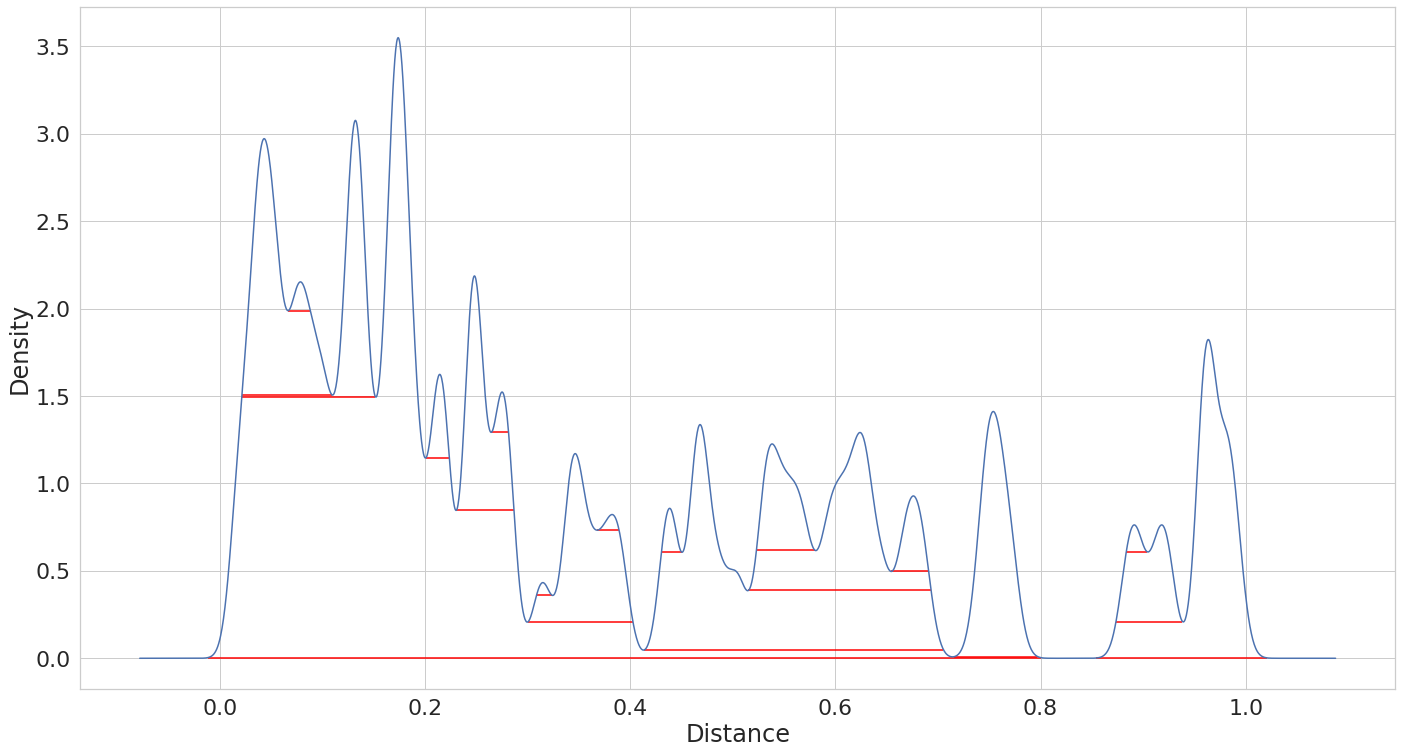

In [139]:
num_samples=2500
vals = get_vals_in_range(node_to_matrix_dict[node], lower_bound=0, upper_bound=1)
print('Vals:', vals)

density, samples, lower_bnd, upper_bnd = get_kde(vals, bandwidth_multiplier=20, num_samples=num_samples)

widths, width_heights, left_pos, right_pos = get_peak_widths(density, lower_bnd, upper_bnd, num_samples=num_samples, rel_height=0.999)
print(widths, width_heights, left_pos, right_pos)

epsilon = max(right_pos)
print('Epsilon:', epsilon)

plt.plot(samples, density)
plt.hlines(y=width_heights, xmin=left_pos, xmax=right_pos, colors='red')
plt.xlabel('Distance');plt.ylabel('Density');plt.tight_layout()
plt.savefig('../../figures/num_meanings/clustering/synthetic_benchmark/palm_example_2500_samples.svg')

In [140]:
epsilon = get_epsilon(node_to_matrix_dict[node], lower_bound=0, upper_bound=1, mode='kde', num_samples=1000, rel_height=0.999, bandwidth_multiplier=20)
epsilon

0.7879221481522014

In [141]:
labels = DBSCAN(min_samples=1, metric='precomputed', eps=0.99).fit_predict(node_to_matrix_dict[node])
print(node_to_idx_dict[node])
print(labels)

{0: 'city_location_city_country_1.csv', 1: 'city_location_city_country_2.csv', 2: 'country_location_city_country_1.csv', 3: 'country_location_country_country_code_1.csv', 4: 'country_location_country_country_code_2.csv', 5: 'country_nature_animal_name_scientific_name_country_1.csv', 6: 'country_nature_animal_name_scientific_name_country_2.csv', 7: 'country_nature_plant_name_scientific_name_family_country_1.csv', 8: 'country_nature_plant_name_scientific_name_family_country_2.csv', 9: 'country_nature_plant_name_scientific_name_family_country_3.csv', 10: 'country_personal_company_name_full_name_country_1.csv', 11: 'country_personal_company_name_full_name_country_2.csv', 12: 'country_personal_company_name_full_name_country_3.csv', 13: 'country_product_grocery_country_1.csv', 14: 'country_product_grocery_country_2.csv'}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
